In [1]:
!pip install transformers
!python -m pip install -U xgboost

     |████████████████████████████████| 1.8MB 12.5MB/s 
     |████████████████████████████████| 2.9MB 45.8MB/s 
     |████████████████████████████████| 890kB 41.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=02be14872ea3f6b49973dc26cce7309ac3d5278f1a4069cac335c89ac5d1f570
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 157.5MB 90kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
# general libraries
#imports
from os.path import join as pathjoin;
from os import listdir;
import os;
import re;
import json;
import matplotlib.pyplot as plt;
import pandas as pd;
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
import numpy
import sklearn.pipeline
from gensim.models import KeyedVectors
from sklearn.model_selection import GridSearchCV
import math,glob

from mlxtend.regressor import StackingRegressor
from sklearn import linear_model
from sklearn.ensemble.forest import RandomForestRegressor as RFR
from sklearn.ensemble.forest import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn import neural_network
import xgboost as xgb


from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random

random.seed(42)
np.random.seed(42)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# bert related libraries
import torch
import tensorflow as tf
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel, AutoModelWithLMHead

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
base_path = '/content/gdrive/My Drive/Mestrado/Conjuntos/DBDC3/'
dev_data_path = pathjoin(base_path,'dev/all')
eval_data_path = pathjoin(base_path,'eval/all')

In [6]:
def loadConversations(path):
    conversations = []
    for f in glob.glob(path + '/*.log.json'):
        json_obj = json.load(open(pathjoin(path,f), encoding='utf-8'))
        json_obj['file_name'] = f
        conversations.append(json_obj)
    return conversations

In [7]:
def SetMajorityVoteAndDistribution(conversations, threshold):
    for c in conversations:
        for t in c['turns']:
            count={}
            count['O']=0
            count['T']=0
            count['X']=0
            hasAnnotations = False
            for a in t['annotations']:
                hasAnnotations = True
                count[a['breakdown']] +=1
            del t['annotations']
            if hasAnnotations:
                #distribution
                t['O'] = count['O']*1.0 / (count['O'] + count['T'] + count['X'])
                t['T'] = count['T']*1.0 / (count['O'] + count['T'] + count['X'])
                t['X'] = count['X']*1.0 / (count['O'] + count['T'] + count['X']) 
                #majorityVoting
                t['class'] = 'O'
                t['class'] = 'X' if t['X']>=t['T'] and t['X']>=t['O'] and t['X']>=threshold else t['class']
                t['class'] = 'T' if t['T']>=t['O'] and t['T']>=t['X'] and t['T']>=threshold else t['class']
                t['class'] = 'O' if t['O']>=t['T'] and t['O']>=t['X'] and t['O']>=threshold else t['class']
                
    return conversations

In [8]:
def resultArray(pipeline, test, testPred):
    #test.sort_values(['file_name', 'user-index'], ascending=[True, True])
    result ={}
    data = {}
    data['turns'] = []
    size = test.shape[0]
    predictedValues = pipeline.predict(testPred)
    predictedProbas = pipeline.predict_proba(testPred)
    for i in range(size):
        data['dialogue-id'] = test.iloc[i]['dialogue-id']
        result[data['dialogue-id']] = data
        predictedValue = scoreToLabel(predictedValues[i])
        predictedProba = predictedProbas[i]
        
        turn ={}
        turn['turn-index'] = int(test.iloc[i]['system-index'])
        turn['labels'] = []
        
        label ={}
        label['breakdown'] = predictedValue
        label['prob-O'] = predictedProba[0]
        label['prob-T'] = predictedProba[1]
        label['prob-X'] = predictedProba[2] 
        
        turn['labels'].append(label)        
        data['turns'].append(turn)
        if  i == size-1 or test.iloc[i]['file_name'] != test.iloc[i+1]['file_name']:
            data = {}
            data['turns'] = []
    return result

In [9]:
def ConversationClassCount(conversations):
    count={}
    count['O']=0
    count['T']=0
    count['X']=0
    for c in conversations:
        for t in c['turns']:
            if 'class' in t:
                count[t['class']] += 1
    return count

In [10]:
def scoreToLabel(score):
    score_float = float(score)
    if score_float<0.4:
        return 'O'
    elif score_float <0.8:
        return 'T'
    else:
        return 'X'

###Métodos de avaliação

In [11]:
def calc_distribution(annotations) :
    count_O = 0
    count_T = 0
    count_X = 0

    for annotation in annotations:
        if annotation['breakdown'] == 'O':
            count_O += 1
        elif annotation['breakdown'] == 'T':
            count_T += 1
        elif annotation['breakdown'] == 'X':
            count_X += 1

    prob_O = count_O*1.0 / (count_O + count_T + count_X)
    prob_T = count_T*1.0 / (count_O + count_T + count_X)
    prob_X = count_X*1.0 / (count_O + count_T + count_X)

    return [prob_O, prob_T, prob_X]

In [12]:
def majority_label(prob_O, prob_T, prob_X, threshold):

    if prob_O >= prob_T and prob_O >= prob_X and prob_O >= threshold:
        return "O"
    elif prob_T >= prob_O and prob_T >= prob_X and prob_T >= threshold:
        return "T"
    elif prob_X >= prob_T and prob_X >= prob_O and prob_X >= threshold:
        return "X"
    else:
        return "O"

In [13]:
def majority_label_lenient(prob_O, prob_T, prob_X, threshold):

    if prob_O >= prob_T + prob_X and prob_O >= threshold:
        return "O_l"
    elif prob_T + prob_X >= prob_O and prob_T + prob_X >= threshold:
        return "X_l"
    else:
        return "O_l"

In [14]:
def kld(p, q):
    k = 0.0
    for i in range(len(p)):
        if p[i] > 0:
            k += p[i] * (math.log(p[i]/q[i],2))
    return k

In [15]:
def jsd(p, q):
    m = []
    for i in range(len(p)):
        m.append((p[i]+q[i])/2.0)

    return (kld(p,m) + kld(q,m)) / 2.0

In [16]:
def mse(p, q):
    total = 0.0

    for i in range(len(p)):
        total += pow(p[i] - q[i],2)

    return total / len(p)

In [17]:
def evaluationAsDict(data_path,eval_data,threshold):

    file_num = 0
    label_num = 0

    correct_num = 0
    incorrect_num = 0

    predO_ansO = 0
    predO_ansT = 0
    predO_ansX = 0
    predT_ansO = 0
    predT_ansT = 0
    predT_ansX = 0
    predX_ansO = 0
    predX_ansT = 0
    predX_ansX = 0

    predO_ansO_l = 0
    predO_ansX_l = 0
    predT_ansO_l = 0
    predT_ansX_l = 0
    predX_ansO_l = 0
    predX_ansX_l = 0

    jsd_O_T_X_sum = 0.0
    jsd_O_TX_sum = 0.0
    jsd_OT_X_sum = 0.0
    mse_O_T_X_sum = 0.0
    mse_O_TX_sum = 0.0
    mse_OT_X_sum = 0.0

    pred_dist_list = []
    ans_dist_list = []

    #parser = argparse.ArgumentParser()
    #parser.add_argument('-p', dest='datapath', action='store', metavar='TESTDIR', required=True,
                        #help='テスト用の対話データが入ったディレクトリ')
    #parser.add_argument('-o', dest='evalpath', action='store', metavar='EVALDIR', required=True,
                        #help='評価用データが入ったディレクトリ')
    #parser.add_argument('-t', dest='threshold', action='store', metavar='THRESHOLD', required=False,
                        #help='正解ラベルを決定するためのしきい値')

    #args = parser.parse_args()

    #data_path = args.datapath
    #eval_path = args.evalpath

    #threshold = 0.0
    #if args.threshold != None:
    #    threshold = float(args.threshold)

    #if not data_path.endswith('/') or not data_path.endswith('\\'):
        #data_path += '/'
    #if not eval_path.endswith('/') or not eval_path.endswith('\\'):
        #eval_path += '/'

    data_files = glob.glob(data_path + '/*log.json')
    
    for f in data_files:
    #for data_json in data_files:
        file_num += 1

        data_fp = open(f, "r")
        data_json = json.load(data_fp)
        data_fp.close()

        dlg_id = data_json["dialogue-id"]
        #eval_fp = open(eval_path + dlg_id + ".labels.json", "r")
        #eval_json = json.load(eval_fp)
        #eval_fp.close()
        
        eval_json = eval_data[dlg_id]
        #print(dlg_id)
        eval_index = 0
        for turn in data_json['turns']:
            if turn['speaker'] == "U" or turn['annotations']==[]:  # modified Sep 17 2017
                continue

            label_num += 1

            ans_prob_dist = calc_distribution(turn['annotations'])
            ans_dist_list.append(ans_prob_dist)
            ans_label = majority_label(ans_prob_dist[0], ans_prob_dist[1], ans_prob_dist[2], threshold)

            ans_label_l = majority_label_lenient(ans_prob_dist[0], ans_prob_dist[1], ans_prob_dist[2], threshold)

            #print(f)
            target_label = eval_json['turns'][eval_index]['labels'][0]
            
            #print(str(ans_label)+','+str(target_label['breakdown'])+','+ str(turn['turn-index'])+','+ str(eval_json['turns'][eval_index]['turn-index']))

            pred_prob_dist = [float(target_label['prob-O']), float(target_label['prob-T']), float(target_label['prob-X'])]
            pred_dist_list.append(pred_prob_dist)

            jsd_O_T_X_sum += jsd(ans_prob_dist,pred_prob_dist)
            jsd_O_TX_sum += jsd([ans_prob_dist[0],ans_prob_dist[1] + ans_prob_dist[2]],[pred_prob_dist[0],pred_prob_dist[1] + pred_prob_dist[2]])
            jsd_OT_X_sum += jsd([ans_prob_dist[0] + ans_prob_dist[1],ans_prob_dist[2]],[pred_prob_dist[0] + pred_prob_dist[1] ,pred_prob_dist[2]])

            mse_O_T_X_sum += mse(ans_prob_dist,pred_prob_dist)
            mse_O_TX_sum += mse([ans_prob_dist[0],ans_prob_dist[1] + ans_prob_dist[2]],[pred_prob_dist[0],pred_prob_dist[1] + pred_prob_dist[2]])
            mse_OT_X_sum += mse([ans_prob_dist[0] + ans_prob_dist[1],ans_prob_dist[2]],[pred_prob_dist[0] + pred_prob_dist[1] ,pred_prob_dist[2]])

            pred_label = target_label['breakdown']
            eval_index += 1

            if pred_label == ans_label:
                correct_num += 1
            else:
                incorrect_num += 1

            if pred_label == "O":
                if ans_label == "O":
                    predO_ansO += 1
                elif ans_label == "T":
                    predO_ansT += 1
                elif ans_label == "X":
                    predO_ansX += 1
            elif pred_label == "T":
                if ans_label == "O":
                    predT_ansO += 1
                elif ans_label == "T":
                    predT_ansT += 1
                elif ans_label == "X":
                    predT_ansX += 1
            elif pred_label == "X":
                if ans_label == "O":
                    predX_ansO += 1
                elif ans_label == "T":
                    predX_ansT += 1
                elif ans_label == "X":
                    predX_ansX += 1

            #lenient
            if pred_label == "O":
                if ans_label_l == "O_l":
                    predO_ansO_l += 1
                elif ans_label_l == "X_l":
                    predO_ansX_l += 1
            elif pred_label == "T":
                if ans_label_l == "O_l":
                    predT_ansO_l += 1
                elif ans_label_l == "X_l":
                    predT_ansX_l += 1
            elif pred_label == "X":
                if ans_label_l == "O_l":
                    predX_ansO_l += 1
                elif ans_label_l == "X_l":
                    predX_ansX_l += 1


#     print correct_num
#     print incorrect_num
#
#     print predO_ansO
#     print predO_ansT
#     print predO_ansX
#     print predT_ansO
#     print predT_ansT
#     print predT_ansX
#     print predX_ansO
#     print predX_ansT
#     print predX_ansX


    #print str(predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l + predO_ansX_l + predO_ansO_l)
    
    print("######### Data Stats #########")
    print("File Num : \t\t" + str(file_num))
    print("System Utterance Num : \t" + str(label_num))
    print("O Label Num : \t\t" + str(predO_ansO + predT_ansO + predX_ansO))
    print("T Label Num : \t\t" + str(predO_ansT + predT_ansT + predX_ansT))
    print("X Label Num : \t\t" + str(predO_ansX + predT_ansX + predX_ansX))
    print("")

    print("######### Results #########")
    print("Accuracy : \t\t%4f" % ((correct_num*1.0) / (correct_num + incorrect_num)) + " (" + str(correct_num) + "/" + str(correct_num + incorrect_num) + ")\n")

    precision_s = 0.0
    recall_s = 0.0
    fmeasure_s = 0.0

    if predX_ansX > 0:
        if (predX_ansO + predX_ansT + predX_ansX) > 0:
            precision_s = predX_ansX*1.0 / (predX_ansO + predX_ansT + predX_ansX)
        if (predO_ansX + predT_ansX + predX_ansX) > 0:
            recall_s = predX_ansX*1.0 / (predO_ansX + predT_ansX + predX_ansX)

    if precision_s > 0 and recall_s > 0:
        fmeasure_s = (2*precision_s*recall_s)/(precision_s + recall_s)

    print("Precision (X) : \t%4f" % (precision_s) + " (" + str(predX_ansX) + "/" + str(predX_ansO + predX_ansT + predX_ansX) + ")")
    print("Recall    (X) : \t%4f" % (recall_s) + " (" + str(predX_ansX) + "/" + str(predO_ansX + predT_ansX + predX_ansX) + ")")
    print("F-measure (X) : \t%4f" % (fmeasure_s) + "\n")


    precision_l = 0.0
    recall_l = 0.0
    fmeasure_l = 0.0
    if (predT_ansX_l + predX_ansX_l) > 0 and (predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l) > 0:
        precision_l = (predT_ansX_l + predX_ansX_l)*1.0 / (predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l)
    if (predT_ansX_l + predX_ansX_l) > 0 and (predO_ansX_l + predT_ansX_l + predX_ansX_l) > 0:
        recall_l = (predT_ansX_l + predX_ansX_l)*1.0 / (predO_ansX_l + predT_ansX_l + predX_ansX_l)
    if precision_l > 0 and recall_l > 0:
        fmeasure_l = (2*precision_l*recall_l)/(precision_l + recall_l)



    print("Precision (T+X) : \t%4f" % (precision_l) + " (" + str(predT_ansX_l + predX_ansX_l) + "/" + str(predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l) + ")")
    print("Recall    (T+X) : \t%4f" % (recall_l) + " (" + str(predT_ansX_l + predX_ansX_l) + "/" + str(predO_ansX_l + predT_ansX_l + predX_ansX_l) + ")")
    print("F-measure (T+X) : \t%4f" % (fmeasure_l) + "\n")

    print("JS divergence (O,T,X) : \t%4f" % (jsd_O_T_X_sum / (correct_num + incorrect_num)))
    print("JS divergence (O,T+X) : \t%4f" % (jsd_O_TX_sum / (correct_num + incorrect_num)))
    print("JS divergence (O+T,X) : \t%4f" % (jsd_OT_X_sum / (correct_num + incorrect_num)) + "\n")

    print("Mean squared error (O,T,X) : \t%4f" % (mse_O_T_X_sum / (correct_num + incorrect_num)))
    print("Mean squared error (O,T+X) : \t%4f" % (mse_O_TX_sum / (correct_num + incorrect_num)))
    print("Mean squared error (O+T,X) : \t%4f" % (mse_OT_X_sum / (correct_num + incorrect_num)))
    print("###########################")
    
    result_ans = {
        "fileNumber":file_num,
        "systemUtterance":label_num,
        "ansO": predO_ansO + predT_ansO + predX_ansO,
        "ansT": predO_ansT + predT_ansT + predX_ansT,
        "ansX": predO_ansX + predT_ansX + predX_ansX,
        "accuracy": ((correct_num*1.0) / (correct_num + incorrect_num)),
        "precisionX": precision_s,
        "predX_ansX":predX_ansX,
        "total_predX": predX_ansO + predX_ansT + predX_ansX,
        "total_ansX": predO_ansX + predT_ansX + predX_ansX,
        "recallX": recall_s,
        "f1X": fmeasure_s,
        
        "precisionTX":precision_l,
        "recallTX": recall_l,
        "f1TX": fmeasure_l,
        
        "totalTXAnsX": predT_ansX_l + predX_ansX_l,
        "totalPredX+PredT" : predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l,
        "totalAnsX" : predO_ansX_l + predT_ansX_l + predX_ansX_l,
        
        "js-O-T-X" : (jsd_O_T_X_sum / (correct_num + incorrect_num)),
        "js-O-T+X" : (jsd_O_TX_sum / (correct_num + incorrect_num)),
        "js-O+T-X" : (jsd_OT_X_sum / (correct_num + incorrect_num)),

        "mse-O-T-X" :  (mse_O_T_X_sum / (correct_num + incorrect_num)),
        "mse-O-T+X" :  (mse_O_TX_sum / (correct_num + incorrect_num)),
        "mse-O+T-X" :  (mse_OT_X_sum / (correct_num + incorrect_num))        
        
    }
    
    return result_ans

In [18]:
def PrepareDataSetWithTail(conversations):
    items = conversations.copy()
    result = []
    for c in items:
        #if c['turns'][0]['speaker']=='S':
            #del c['turns'][0]
        turns_len = len(c['turns'])
        userTurnTail = ''
        systemTurnTail = ''
        for i in range(0,turns_len):
            if i == 0 and c['turns'][i]['speaker'] == 'S':
                line = {}
                line['file_name'] = c['file_name']
                line['dialogue-id'] = c['dialogue-id']
                line['user-index'] = c['turns'][i]['turn-index']
                line['user-utterance'] = ''
                line['system-utterance'] = c['turns'][i]['utterance']                
                #line['user-utterance-tail'] = ''
                #line['system-utterance-tail'] = c['turns'][i]['utterance']                
                line['system-index'] = c['turns'][i]['turn-index']                
                line['O'] = 1
                line['T'] = 0
                line['X'] = 0
                line['class']=0
                result.append(line)
                
            if i+1<turns_len and c['turns'][i]['speaker'] == 'U' and c['turns'][i+1]['speaker'] == 'S':
                line = {}
                line['file_name'] = c['file_name']
                line['dialogue-id'] = c['dialogue-id']
                line['user-index'] = c['turns'][i]['turn-index']
                
                #userTurnTail = userTurnTail + ' ' + c['turns'][i]['utterance']
                line['user-utterance'] = c['turns'][i]['utterance']
                
                #systemTurnTail = systemTurnTail + ' ' + c['turns'][i+1]['utterance']
                line['system-utterance'] = c['turns'][i+1]['utterance']
                
                #line['user-utterance-tail'] = GetLastNTurns(c['turns'],i,windowSize)
                #line['system-utterance-tail'] = GetLastNTurns(c['turns'],i+1,windowSize)
                
                line['system-index'] = c['turns'][i+1]['turn-index']                
                line['O'] = c['turns'][i+1]['O']
                line['T'] = c['turns'][i+1]['T']
                line['X'] = c['turns'][i+1]['X']
                if c['turns'][i+1]['class'] == 'O':
                    line['class']=0
                elif c['turns'][i+1]['class'] == 'T':
                    line['class'] = 0.5
                elif c['turns'][i+1]['class'] == 'X':
                    line['class'] = 1
                else:
                    line['class'] = None
                #line['class'] = c['turns'][i+1]['class']
                result.append(line)
    return result

### Computando Dados

In [19]:
json_dev_dev = SetMajorityVoteAndDistribution(loadConversations(dev_data_path),0)
json_dev_test = SetMajorityVoteAndDistribution(loadConversations(eval_data_path),0)

### BERT

In [20]:
def addBert(data, columnName, newColumn):
  english = 'bert-base-cased'
  portuguese = "neuralmind/bert-large-portuguese-cased",
  multilingual = "bert-base-multilingual-cased"

  bert_config ={
      'en' :'bert-base-cased',
      'pt': "neuralmind/bert-large-portuguese-cased",
      'fr':'dbmdz/bert-base-french-europeana-cased',
      'sp': "dccuchile/bert-base-spanish-wwm-cased",
      'it': "dbmdz/bert-base-italian-cased",
      'pl': "dkleczek/bert-base-polish-cased-v1",
      'all':{
          'model': "bert-base-multilingual-cased"
      }
  }
  data[columnName].fillna(' ',inplace=True)
  tokenizer = AutoTokenizer.from_pretrained(english)
  tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t), data[columnName]))
  result = pd.DataFrame({'token_len':[len(t) for t in tokens]}).describe(percentiles=[0.25,0.5,0.75,0.8,0.9,0.99,1]).T
  display(result)
  max_size = result['max']+5

  tokenizer = AutoTokenizer.from_pretrained(english)
  model = AutoModel.from_pretrained(english).cuda()

  MAXLENGTH = int(max_size)
  tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:MAXLENGTH-1], data[columnName]))
  tokens_ids = list(map(tokenizer.convert_tokens_to_ids, tokens))
  tokens_ids = tf.keras.preprocessing.sequence.pad_sequences(tokens_ids, maxlen=MAXLENGTH, truncating='post', padding='post', dtype='int64')
  tensors = torch.tensor(tokens_ids)
  dataloader = DataLoader(TensorDataset(tensors), batch_size=16)
  with torch.no_grad():
      results = []
      for t in tqdm(iter(dataloader)):
          t = t[0]
          result = model(t.cuda())
          result = result[0][range(len(t)), -1, :]
          results.append(result.cpu())
      results = torch.cat(results).numpy()
  data[newColumn]= results.tolist()

In [21]:
train = pd.DataFrame(PrepareDataSetWithTail(json_dev_dev))
test = pd.DataFrame(PrepareDataSetWithTail(json_dev_test))

In [22]:
addBert(train,'user-utterance','user-bert')
addBert(train,'system-utterance','system-bert')

,count,mean,std,min,25%,50%,75%,80%,90%,99%,100%,max
token_len,4335.0,7.328258,4.348243,1.0,4.0,7.0,9.0,10.0,13.0,21.0,33.0,33.0


100%|██████████| 271/271 [00:03<00:00, 68.80it/s]


,count,mean,std,min,25%,50%,75%,80%,90%,99%,100%,max
token_len,4335.0,10.397001,8.03614,1.0,5.0,8.0,14.0,15.0,20.0,39.0,72.0,72.0


100%|██████████| 271/271 [00:06<00:00, 41.84it/s]


In [23]:
addBert(test,'user-utterance','user-bert')
addBert(test,'system-utterance','system-bert')

,count,mean,std,min,25%,50%,75%,80%,90%,99%,100%,max
token_len,2089.0,7.337003,4.445323,1.0,4.0,7.0,9.0,10.0,12.0,23.0,46.0,46.0


100%|██████████| 131/131 [00:02<00:00, 59.88it/s]


,count,mean,std,min,25%,50%,75%,80%,90%,99%,100%,max
token_len,2089.0,10.243179,7.85301,1.0,4.0,8.0,14.0,15.0,20.0,38.0,63.0,63.0


100%|██████████| 131/131 [00:02<00:00, 48.94it/s]


###Transformers

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [25]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse

class DenseTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        return self.transform(X=X, y=y)

In [26]:
import numpy
from sklearn.base import BaseEstimator, TransformerMixin
class WindowItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key, conversationKey, windowSize):
        self.key = key
        self.conversationKey = conversationKey
        self.windowSize =windowSize

    def fit(self, x, y=None):
        return self
    
    def getLastXTurns(self,turns,index,startIndex,n):
        arrayToResult = numpy.array(turns[index])
        i = 1
        while n > 0 and index > startIndex:
            i = i+1
            index = index -1
            n = n-1
            arrayToResult = arrayToResult + numpy.array(turns[index])
        return arrayToResult / i

    def doExecute(self,arrayTest, conversationIds, windowSize):
        newArrayTest =[]
        lastId = conversationIds[0]
        lastStartIndex = 0
        for index in range(len(arrayTest)):
            if lastId != conversationIds[index]:
                lastId = conversationIds[index]
                lastStartIndex = index
            newArrayTest.append(self.getLastXTurns(arrayTest,index,lastStartIndex,windowSize))
        return newArrayTest
        
    def transform(self, data_dict):
        return self.doExecute(data_dict[self.key], data_dict[self.conversationKey], self.windowSize)

In [27]:
import numpy as np
class ArrayCaster(BaseEstimator, TransformerMixin):
  def fit(self, x, y=None):
    return self

  def transform(self, data):
    return np.transpose(np.matrix(data))

### Pipeline

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
def build_pipeline(params):
    pipeline = sklearn.pipeline.Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('user-utterance', Pipeline([
                ('selector', ItemSelector(key='user-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),

            ('system-utterance', Pipeline([
                ('selector', ItemSelector(key='system-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),
            
            ('user-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='user-utterance-tail'))
                ('userWindowSelector', WindowItemSelector(key='user-bert',
                                                          conversationKey='dialogue-id',
                                                          windowSize=params['windowSize']))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),
            
            ('system-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='system-utterance-tail'))
                ('systemWindowSelector', WindowItemSelector(key='system-bert',
                                                            conversationKey='dialogue-id',
                                                            windowSize=params['windowSize']))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),

            ('user-turn', Pipeline([
                ('selector', ItemSelector(key='user-index')),
                ('caster', ArrayCaster())
            ])),
             
            ('system-turn', Pipeline([
                ('selector', ItemSelector(key='system-index')),
                ('caster', ArrayCaster())
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'user-utterance': 1.0,
            'system-utterance': 1.0,
            'user-utterance-tail': 1.0,
            'system-utterance-tail': 1.0,
            'user-turn': 1.0,
            'system-turn':1.0,
            'kernel':'linear',
            'probability':True
        },
    )),
    ('clf', GBR(n_estimators=params['gbr__n_estimators'],
                learning_rate=params['gbr__learning_rate'],
                max_depth=params['gbr__max_depth'],
                random_state=0))])
    
    return pipeline



tuned_parameters = {
    'windowSize': 7,
    'tfidf__min_df': 5,
    'tfidf__max_df': 0.9746491405118024,
    'gbr__n_estimators': 142,
    'gbr__learning_rate': 0.01,
    'gbr__max_depth': 3
}
pipeline = build_pipeline(tuned_parameters)

pipeline.fit(train, train['class'])

trainPred = pipeline.predict(train)
testPred = pipeline.predict(test)

classifier=DecisionTreeClassifier(max_depth=4, max_leaf_nodes=3, class_weight="balanced", random_state=0)
classifier.fit(trainPred.reshape(-1,1), train['class'].astype(str).values.reshape(-1,1))

predicted = resultArray(classifier, test, testPred.reshape(-1,1))
output = evaluationAsDict(eval_data_path, predicted, 0)

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		757
T Label Num : 		479
X Label Num : 		764

######### Results #########
Accuracy : 		0.379500 (759/2000)

Precision (X) : 	0.430804 (386/896)
Recall    (X) : 	0.505236 (386/764)
F-measure (X) : 	0.465060

Precision (T+X) : 	0.787500 (1449/1840)
Recall    (T+X) : 	0.958968 (1449/1511)
F-measure (T+X) : 	0.864816

JS divergence (O,T,X) : 	0.096925
JS divergence (O,T+X) : 	0.057859
JS divergence (O+T,X) : 	0.069677

Mean squared error (O,T,X) : 	0.056255
Mean squared error (O,T+X) : 	0.063681
Mean squared error (O+T,X) : 	0.078320
###########################


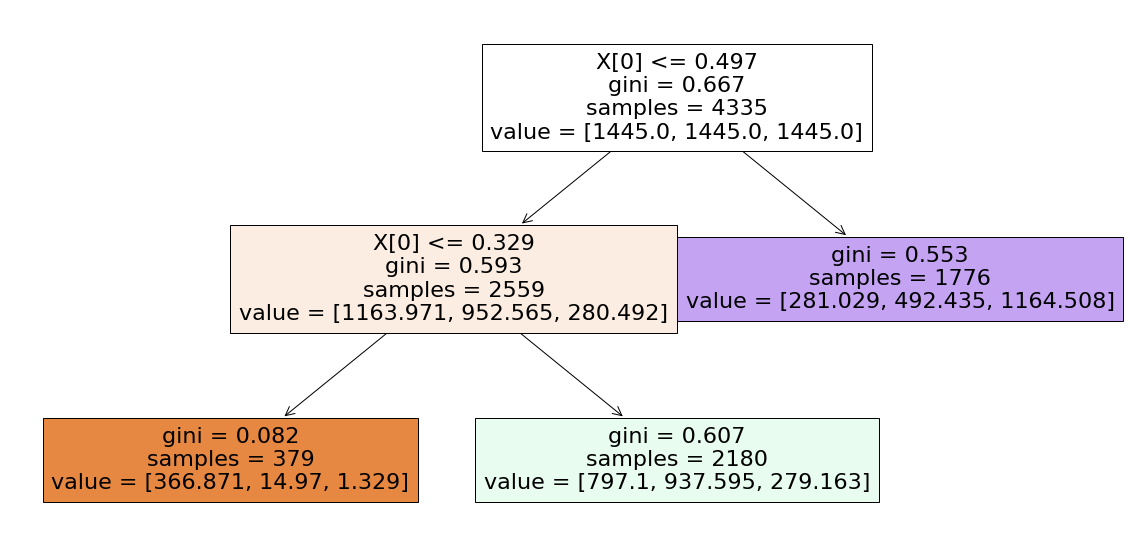

In [29]:
plt.figure(figsize=(20,10)) 
plot_tree(classifier, filled=True) 
plt.show()

In [ ]:
dict = {}
for p in predicted:
    for t in predicted[p]['turns']:
        dict[p + '-' + str(t['turn-index'])]= t['labels'][0]['breakdown']
json.dumps(dict)

'{"YIT0008-0": "O", "YIT0008-2": "T", "YIT0008-4": "T", "YIT0008-6": "T", "YIT0008-8": "T", "YIT0008-10": "T", "YIT0008-12": "T", "YIT0008-14": "X", "YIT0008-16": "T", "YIT0008-18": "T", "YIT0008-20": "T", "YIT0009-0": "O", "YIT0009-2": "T", "YIT0009-4": "T", "YIT0009-6": "T", "YIT0009-8": "T", "YIT0009-10": "T", "YIT0009-12": "T", "YIT0009-14": "X", "YIT0009-16": "X", "YIT0009-18": "T", "YIT0009-20": "T", "YIT0003-0": "O", "YIT0003-2": "T", "YIT0003-4": "T", "YIT0003-6": "T", "YIT0003-8": "T", "YIT0003-10": "T", "YIT0003-12": "T", "YIT0003-14": "T", "YIT0003-16": "T", "YIT0003-18": "T", "YIT0003-20": "T", "YIT0040-0": "O", "YIT0040-2": "T", "YIT0040-4": "T", "YIT0040-6": "T", "YIT0040-8": "T", "YIT0040-10": "X", "YIT0040-12": "X", "YIT0040-14": "T", "YIT0040-16": "T", "YIT0040-18": "X", "YIT0040-20": "T", "YIT0041-0": "O", "YIT0041-2": "T", "YIT0041-4": "T", "YIT0041-6": "T", "YIT0041-8": "T", "YIT0041-10": "T", "YIT0041-12": "X", "YIT0041-14": "T", "YIT0041-16": "T", "YIT0041-18": "X

### Treino

In [ ]:
from tqdm import tqdm
import numpy as np

def build_pipeline(params):
    pipeline = sklearn.pipeline.Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('user-utterance', Pipeline([
                ('selector', ItemSelector(key='user-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),

            ('system-utterance', Pipeline([
                ('selector', ItemSelector(key='system-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),
            
            ('user-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='user-utterance-tail'))
                ('userWindowSelector', WindowItemSelector(key='user-bert',
                                                          conversationKey='dialogue-id',
                                                          windowSize=params['windowSize']))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),
            
            ('system-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='system-utterance-tail'))
                ('systemWindowSelector', WindowItemSelector(key='system-bert',
                                                            conversationKey='dialogue-id',
                                                            windowSize=params['windowSize']))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ]))

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'user-utterance': 1.0,
            'system-utterance': 1.0,
            'user-utterance-tail': 1.0,
            'system-utterance-tail': 1.0,
            'user-turn': 1.0,
            'system-turn':1.0,
            'kernel':'linear',
            'probability':True
        },
    )),
    ('clf', GBR(n_estimators=params['gbr__n_estimators'],
                learning_rate=params['gbr__learning_rate'],
                max_depth=params['gbr__max_depth'],
                random_state=0))])
    
    return pipeline

from sklearn.tree import DecisionTreeClassifier, plot_tree

N_ITER = 100

best_model = None
best_classifier = None
best_result = -np.inf
tuned_parameters = None

results_iter = []

for i in tqdm(range(N_ITER)):
    parameters = {
        'windowSize': np.random.randint(low=3, high=11),
        'tfidf__min_df': np.random.randint(low=2, high=6),
        'tfidf__max_df': np.random.uniform(low=0.9, high=1.0),
        'gbr__n_estimators': np.random.randint(low=15, high=150),
        'gbr__learning_rate': np.random.choice(np.logspace(-3, -1, 5)),
        'gbr__max_depth': np.random.randint(low=3, high=6)
    }
    print(parameters)
    pipeline = build_pipeline(parameters)
    pipeline.fit(train, train['class'])
    
    trainPred = pipeline.predict(train)
    testPred = pipeline.predict(test)
    
    classifier = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=3, class_weight="balanced", random_state=0)
    classifier.fit(trainPred.reshape(-1,1),train['class'].astype(str).values.reshape(-1,1))
    trainPred2 = classifier.predict(trainPred.reshape(-1,1))
    testPred2 = classifier.predict(testPred.reshape(-1,1))
    
    predicted = resultArray(classifier, test, testPred.reshape(-1,1))
    output = evaluationAsDict(eval_data_path,predicted,0.5)
    
    results_iter.append(dict(**parameters,**output,**{"iter":i}))

    if output['f1X']>best_result:
        best_result = output['f1X']
        best_model = pipeline
        best_classifier = classifier
        tuned_parameters = parameters

print(tuned_parameters)

testPred = best_model.predict(test)
predicted = resultArray(best_classifier, test, testPred.reshape(-1,1))
output = evaluationAsDict(eval_data_path,predicted,0.5)

  0%|          | 0/100 [00:00<?, ?it/s]

{'windowSize': 9, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9950714306409916, 'gbr__n_estimators': 121, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 3}


  1%|          | 1/100 [03:10<5:13:30, 190.01s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.330081 (406/1230)

Precision (X) : 	0.409396 (61/149)
Recall    (X) : 	0.199346 (61/306)
F-measure (X) : 	0.268132

Precision (T+X) : 	0.841727 (702/834)
Recall    (T+X) : 	0.690265 (702/1017)
F-measure (T+X) : 	0.758509

JS divergence (O,T,X) : 	0.194788
JS divergence (O,T+X) : 	0.081058
JS divergence (O+T,X) : 	0.147932

Mean squared error (O,T,X) : 	0.106588
Mean squared error (O,T+X) : 	0.090713
Mean squared error (O+T,X) : 	0.136734
###########################
{'windowSize': 9, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9155994520336203, 'gbr__n_estimators': 89, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 3}


  2%|▏         | 2/100 [06:25<5:12:56, 191.60s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.631707 (777/1230)

Precision (X) : 	0.372308 (121/325)
Recall    (X) : 	0.395425 (121/306)
F-measure (X) : 	0.383518

Precision (T+X) : 	0.840000 (273/325)
Recall    (T+X) : 	0.268437 (273/1017)
F-measure (T+X) : 	0.406855

JS divergence (O,T,X) : 	0.094971
JS divergence (O,T+X) : 	0.042697
JS divergence (O+T,X) : 	0.076134

Mean squared error (O,T,X) : 	0.052968
Mean squared error (O,T+X) : 	0.047578
Mean squared error (O+T,X) : 	0.084595
###########################
{'windowSize': 6, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9708072577796045, 'gbr__n_estimators': 67, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 4}


  3%|▎         | 3/100 [08:41<4:42:39, 174.84s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.265041 (326/1230)

Precision (X) : 	0.300955 (189/628)
Recall    (X) : 	0.617647 (189/306)
F-measure (X) : 	0.404711

Precision (T+X) : 	0.839572 (942/1122)
Recall    (T+X) : 	0.926254 (942/1017)
F-measure (T+X) : 	0.880785

JS divergence (O,T,X) : 	0.088012
JS divergence (O,T+X) : 	0.048518
JS divergence (O+T,X) : 	0.067421

Mean squared error (O,T,X) : 	0.051257
Mean squared error (O,T+X) : 	0.056296
Mean squared error (O+T,X) : 	0.075494
###########################
{'windowSize': 8, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9181824967207101, 'gbr__n_estimators': 35, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 4}


  4%|▍         | 4/100 [10:27<4:07:08, 154.47s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.537398 (661/1230)

Precision (X) : 	0.316310 (192/607)
Recall    (X) : 	0.627451 (192/306)
F-measure (X) : 	0.420591

Precision (T+X) : 	0.845140 (513/607)
Recall    (T+X) : 	0.504425 (513/1017)
F-measure (T+X) : 	0.631773

JS divergence (O,T,X) : 	0.074799
JS divergence (O,T+X) : 	0.040975
JS divergence (O+T,X) : 	0.056027

Mean squared error (O,T,X) : 	0.044946
Mean squared error (O,T+X) : 	0.046491
Mean squared error (O+T,X) : 	0.067099
###########################
{'windowSize': 8, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9431945018642116, 'gbr__n_estimators': 63, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 5}


  5%|▌         | 5/100 [15:28<5:13:47, 198.18s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.189431 (233/1230)

Precision (X) : 	0.363057 (114/314)
Recall    (X) : 	0.372549 (114/306)
F-measure (X) : 	0.367742

Precision (T+X) : 	0.836348 (971/1161)
Recall    (T+X) : 	0.954769 (971/1017)
F-measure (T+X) : 	0.891644

JS divergence (O,T,X) : 	0.128031
JS divergence (O,T+X) : 	0.060087
JS divergence (O+T,X) : 	0.102799

Mean squared error (O,T,X) : 	0.070298
Mean squared error (O,T+X) : 	0.058238
Mean squared error (O+T,X) : 	0.114458
###########################
{'windowSize': 9, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9046665663213616, 'gbr__n_estimators': 29, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 5}


  6%|▌         | 6/100 [17:14<4:27:11, 170.54s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.158537 (195/1230)

Precision (X) : 	0.333333 (97/291)
Recall    (X) : 	0.316993 (97/306)
F-measure (X) : 	0.324958

Precision (T+X) : 	0.831499 (982/1181)
Recall    (T+X) : 	0.965585 (982/1017)
F-measure (T+X) : 	0.893540

JS divergence (O,T,X) : 	0.103026
JS divergence (O,T+X) : 	0.049224
JS divergence (O+T,X) : 	0.081896

Mean squared error (O,T,X) : 	0.058945
Mean squared error (O,T+X) : 	0.053582
Mean squared error (O+T,X) : 	0.093166
###########################
{'windowSize': 6, 'tfidf__min_df': 5, 'tfidf__max_df': 0.946676289324798, 'gbr__n_estimators': 65, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 3}


  7%|▋         | 7/100 [18:56<3:52:31, 150.02s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.358537 (441/1230)

Precision (X) : 	0.394977 (173/438)
Recall    (X) : 	0.565359 (173/306)
F-measure (X) : 	0.465054

Precision (T+X) : 	0.851735 (810/951)
Recall    (T+X) : 	0.796460 (810/1017)
F-measure (T+X) : 	0.823171

JS divergence (O,T,X) : 	0.157061
JS divergence (O,T+X) : 	0.081806
JS divergence (O+T,X) : 	0.121712

Mean squared error (O,T,X) : 	0.089253
Mean squared error (O,T+X) : 	0.077846
Mean squared error (O+T,X) : 	0.131912
###########################
{'windowSize': 9, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9948885537253334, 'gbr__n_estimators': 74, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 4}


  8%|▊         | 8/100 [22:23<4:16:18, 167.16s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.480488 (591/1230)

Precision (X) : 	0.346505 (114/329)
Recall    (X) : 	0.372549 (114/306)
F-measure (X) : 	0.359055

Precision (T+X) : 	0.865353 (527/609)
Recall    (T+X) : 	0.518191 (527/1017)
F-measure (T+X) : 	0.648216

JS divergence (O,T,X) : 	0.102195
JS divergence (O,T+X) : 	0.044241
JS divergence (O+T,X) : 	0.083094

Mean squared error (O,T,X) : 	0.055604
Mean squared error (O,T+X) : 	0.050797
Mean squared error (O+T,X) : 	0.088894
###########################
{'windowSize': 3, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9097672114006384, 'gbr__n_estimators': 98, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 5}


  9%|▉         | 9/100 [28:11<5:35:43, 221.36s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.317073 (390/1230)

Precision (X) : 	0.357430 (89/249)
Recall    (X) : 	0.290850 (89/306)
F-measure (X) : 	0.320721

Precision (T+X) : 	0.859307 (794/924)
Recall    (T+X) : 	0.780728 (794/1017)
F-measure (T+X) : 	0.818135

JS divergence (O,T,X) : 	0.237837
JS divergence (O,T+X) : 	0.105021
JS divergence (O+T,X) : 	0.160644

Mean squared error (O,T,X) : 	0.137333
Mean squared error (O,T+X) : 	0.102075
Mean squared error (O+T,X) : 	0.151839
###########################
{'windowSize': 6, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9609996657782621, 'gbr__n_estimators': 22, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 4}


 10%|█         | 10/100 [29:07<4:17:44, 171.83s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.401626 (494/1230)

Precision (X) : 	0.305221 (152/498)
Recall    (X) : 	0.496732 (152/306)
F-measure (X) : 	0.378109

Precision (T+X) : 	0.847478 (689/813)
Recall    (T+X) : 	0.677483 (689/1017)
F-measure (T+X) : 	0.753005

JS divergence (O,T,X) : 	0.085872
JS divergence (O,T+X) : 	0.052059
JS divergence (O+T,X) : 	0.063976

Mean squared error (O,T,X) : 	0.051672
Mean squared error (O,T+X) : 	0.059651
Mean squared error (O+T,X) : 	0.075617
###########################
{'windowSize': 3, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9182236087788063, 'gbr__n_estimators': 146, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 4}


 11%|█         | 11/100 [34:05<5:10:54, 209.60s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.632520 (778/1230)

Precision (X) : 	0.367742 (114/310)
Recall    (X) : 	0.372549 (114/306)
F-measure (X) : 	0.370130

Precision (T+X) : 	0.848387 (263/310)
Recall    (T+X) : 	0.258604 (263/1017)
F-measure (T+X) : 	0.396383

JS divergence (O,T,X) : 	0.099536
JS divergence (O,T+X) : 	0.052682
JS divergence (O+T,X) : 	0.079187

Mean squared error (O,T,X) : 	0.055952
Mean squared error (O,T+X) : 	0.054896
Mean squared error (O+T,X) : 	0.089334
###########################
{'windowSize': 8, 'tfidf__min_df': 3, 'tfidf__max_df': 0.954671027934328, 'gbr__n_estimators': 68, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 5}


 12%|█▏        | 12/100 [38:01<5:19:14, 217.67s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.282927 (348/1230)

Precision (X) : 	0.368000 (92/250)
Recall    (X) : 	0.300654 (92/306)
F-measure (X) : 	0.330935

Precision (T+X) : 	0.851000 (851/1000)
Recall    (T+X) : 	0.836775 (851/1017)
F-measure (T+X) : 	0.843827

JS divergence (O,T,X) : 	0.300016
JS divergence (O,T+X) : 	0.119601
JS divergence (O+T,X) : 	0.208155

Mean squared error (O,T,X) : 	0.173040
Mean squared error (O,T+X) : 	0.119893
Mean squared error (O+T,X) : 	0.182147
###########################
{'windowSize': 4, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9449754133369765, 'gbr__n_estimators': 28, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 3}


 13%|█▎        | 13/100 [39:10<4:10:55, 173.05s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.217073 (267/1230)

Precision (X) : 	0.350365 (144/411)
Recall    (X) : 	0.470588 (144/306)
F-measure (X) : 	0.401674

Precision (T+X) : 	0.840453 (964/1147)
Recall    (T+X) : 	0.947886 (964/1017)
F-measure (T+X) : 	0.890943

JS divergence (O,T,X) : 	0.092603
JS divergence (O,T+X) : 	0.055120
JS divergence (O+T,X) : 	0.067795

Mean squared error (O,T,X) : 	0.053933
Mean squared error (O,T+X) : 	0.061311
Mean squared error (O+T,X) : 	0.075385
###########################
{'windowSize': 8, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9844533848678152, 'gbr__n_estimators': 96, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 4}


 14%|█▍        | 14/100 [42:21<4:15:34, 178.31s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.282927 (348/1230)

Precision (X) : 	0.371622 (110/296)
Recall    (X) : 	0.359477 (110/306)
F-measure (X) : 	0.365449

Precision (T+X) : 	0.848697 (847/998)
Recall    (T+X) : 	0.832842 (847/1017)
F-measure (T+X) : 	0.840695

JS divergence (O,T,X) : 	0.267808
JS divergence (O,T+X) : 	0.108163
JS divergence (O+T,X) : 	0.193783

Mean squared error (O,T,X) : 	0.154616
Mean squared error (O,T+X) : 	0.107063
Mean squared error (O+T,X) : 	0.178357
###########################
{'windowSize': 3, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9607034247686684, 'gbr__n_estimators': 55, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 5}


 15%|█▌        | 15/100 [44:44<3:57:43, 167.81s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.206504 (254/1230)

Precision (X) : 	0.394191 (95/241)
Recall    (X) : 	0.310458 (95/306)
F-measure (X) : 	0.347349

Precision (T+X) : 	0.841486 (929/1104)
Recall    (T+X) : 	0.913471 (929/1017)
F-measure (T+X) : 	0.876002

JS divergence (O,T,X) : 	0.264491
JS divergence (O,T+X) : 	0.102070
JS divergence (O+T,X) : 	0.179421

Mean squared error (O,T,X) : 	0.157491
Mean squared error (O,T+X) : 	0.100521
Mean squared error (O+T,X) : 	0.166438
###########################
{'windowSize': 7, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9015636406741194, 'gbr__n_estimators': 23, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 5}


 16%|█▌        | 16/100 [46:47<3:36:01, 154.31s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.426016 (524/1230)

Precision (X) : 	0.280702 (240/855)
Recall    (X) : 	0.784314 (240/306)
F-measure (X) : 	0.413437

Precision (T+X) : 	0.861988 (737/855)
Recall    (T+X) : 	0.724680 (737/1017)
F-measure (T+X) : 	0.787393

JS divergence (O,T,X) : 	0.075123
JS divergence (O,T+X) : 	0.038754
JS divergence (O+T,X) : 	0.057426

Mean squared error (O,T,X) : 	0.041994
Mean squared error (O,T+X) : 	0.040909
Mean squared error (O+T,X) : 	0.062662
###########################
{'windowSize': 5, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9706857343847617, 'gbr__n_estimators': 47, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 3}


 17%|█▋        | 17/100 [48:14<3:05:22, 134.00s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.299187 (368/1230)

Precision (X) : 	0.318792 (190/596)
Recall    (X) : 	0.620915 (190/306)
F-measure (X) : 	0.421286

Precision (T+X) : 	0.836004 (887/1061)
Recall    (T+X) : 	0.872173 (887/1017)
F-measure (T+X) : 	0.853705

JS divergence (O,T,X) : 	0.104351
JS divergence (O,T+X) : 	0.069623
JS divergence (O+T,X) : 	0.071604

Mean squared error (O,T,X) : 	0.061982
Mean squared error (O,T+X) : 	0.081096
Mean squared error (O+T,X) : 	0.075772
###########################
{'windowSize': 4, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9651077025501944, 'gbr__n_estimators': 42, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 4}


 18%|█▊        | 18/100 [49:55<2:49:45, 124.21s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.582114 (716/1230)

Precision (X) : 	0.350575 (183/522)
Recall    (X) : 	0.598039 (183/306)
F-measure (X) : 	0.442029

Precision (T+X) : 	0.881226 (460/522)
Recall    (T+X) : 	0.452311 (460/1017)
F-measure (T+X) : 	0.597791

JS divergence (O,T,X) : 	0.076143
JS divergence (O,T+X) : 	0.040583
JS divergence (O+T,X) : 	0.056907

Mean squared error (O,T,X) : 	0.042533
Mean squared error (O,T+X) : 	0.046023
Mean squared error (O+T,X) : 	0.063081
###########################
{'windowSize': 3, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9370818252198266, 'gbr__n_estimators': 76, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 5}


 19%|█▉        | 19/100 [53:11<3:16:48, 145.79s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.235772 (290/1230)

Precision (X) : 	0.354396 (129/364)
Recall    (X) : 	0.421569 (129/306)
F-measure (X) : 	0.385075

Precision (T+X) : 	0.843173 (914/1084)
Recall    (T+X) : 	0.898722 (914/1017)
F-measure (T+X) : 	0.870062

JS divergence (O,T,X) : 	0.360974
JS divergence (O,T+X) : 	0.152631
JS divergence (O+T,X) : 	0.237131

Mean squared error (O,T,X) : 	0.205454
Mean squared error (O,T+X) : 	0.135538
Mean squared error (O+T,X) : 	0.208365
###########################
{'windowSize': 6, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9274721792990064, 'gbr__n_estimators': 49, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 5}


 20%|██        | 20/100 [55:11<3:04:06, 138.08s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.466667 (574/1230)

Precision (X) : 	0.300797 (151/502)
Recall    (X) : 	0.493464 (151/306)
F-measure (X) : 	0.373762

Precision (T+X) : 	0.826220 (542/656)
Recall    (T+X) : 	0.532940 (542/1017)
F-measure (T+X) : 	0.647938

JS divergence (O,T,X) : 	0.121023
JS divergence (O,T+X) : 	0.061751
JS divergence (O+T,X) : 	0.101293

Mean squared error (O,T,X) : 	0.069733
Mean squared error (O,T+X) : 	0.069256
Mean squared error (O+T,X) : 	0.114774
###########################
{'windowSize': 7, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9713244787222995, 'gbr__n_estimators': 15, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 4}


 21%|██        | 21/100 [55:52<2:23:25, 108.93s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.346341 (426/1230)

Precision (X) : 	0.375000 (162/432)
Recall    (X) : 	0.529412 (162/306)
F-measure (X) : 	0.439024

Precision (T+X) : 	0.849474 (807/950)
Recall    (T+X) : 	0.793510 (807/1017)
F-measure (T+X) : 	0.820539

JS divergence (O,T,X) : 	0.135658
JS divergence (O,T+X) : 	0.070456
JS divergence (O+T,X) : 	0.112399

Mean squared error (O,T,X) : 	0.078393
Mean squared error (O,T+X) : 	0.069568
Mean squared error (O+T,X) : 	0.125045
###########################
{'windowSize': 9, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9256068322761324, 'gbr__n_estimators': 41, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 5}


 22%|██▏       | 22/100 [57:51<2:25:19, 111.79s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.164228 (202/1230)

Precision (X) : 	0.295547 (73/247)
Recall    (X) : 	0.238562 (73/306)
F-measure (X) : 	0.264014

Precision (T+X) : 	0.840491 (959/1141)
Recall    (T+X) : 	0.942970 (959/1017)
F-measure (T+X) : 	0.888786

JS divergence (O,T,X) : 	0.077144
JS divergence (O,T+X) : 	0.038947
JS divergence (O+T,X) : 	0.057166

Mean squared error (O,T,X) : 	0.043589
Mean squared error (O,T+X) : 	0.044046
Mean squared error (O+T,X) : 	0.063003
###########################
{'windowSize': 9, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9025419126744095, 'gbr__n_estimators': 77, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 3}


 23%|██▎       | 23/100 [1:00:40<2:45:33, 129.01s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.547967 (674/1230)

Precision (X) : 	0.323322 (183/566)
Recall    (X) : 	0.598039 (183/306)
F-measure (X) : 	0.419725

Precision (T+X) : 	0.858657 (486/566)
Recall    (T+X) : 	0.477876 (486/1017)
F-measure (T+X) : 	0.614024

JS divergence (O,T,X) : 	0.076292
JS divergence (O,T+X) : 	0.036139
JS divergence (O+T,X) : 	0.057381

Mean squared error (O,T,X) : 	0.042257
Mean squared error (O,T+X) : 	0.040740
Mean squared error (O+T,X) : 	0.063277
###########################
{'windowSize': 10, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9907566473926093, 'gbr__n_estimators': 43, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 3}


 24%|██▍       | 24/100 [1:01:49<2:20:31, 110.94s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.605691 (745/1230)

Precision (X) : 	0.323353 (108/334)
Recall    (X) : 	0.352941 (108/306)
F-measure (X) : 	0.337500

Precision (T+X) : 	0.850299 (284/334)
Recall    (T+X) : 	0.279253 (284/1017)
F-measure (T+X) : 	0.420429

JS divergence (O,T,X) : 	0.101489
JS divergence (O,T+X) : 	0.045757
JS divergence (O+T,X) : 	0.082345

Mean squared error (O,T,X) : 	0.057124
Mean squared error (O,T+X) : 	0.049107
Mean squared error (O+T,X) : 	0.093036
###########################
{'windowSize': 10, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9289751452913768, 'gbr__n_estimators': 100, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 4}


 25%|██▌       | 25/100 [1:05:31<3:00:37, 144.50s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.511382 (629/1230)

Precision (X) : 	0.400000 (48/120)
Recall    (X) : 	0.156863 (48/306)
F-measure (X) : 	0.225352

Precision (T+X) : 	0.878914 (421/479)
Recall    (T+X) : 	0.413963 (421/1017)
F-measure (T+X) : 	0.562834

JS divergence (O,T,X) : 	0.173123
JS divergence (O,T+X) : 	0.068528
JS divergence (O+T,X) : 	0.142636

Mean squared error (O,T,X) : 	0.086315
Mean squared error (O,T+X) : 	0.076588
Mean squared error (O+T,X) : 	0.130063
###########################
{'windowSize': 4, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9295633685837714, 'gbr__n_estimators': 148, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 4}


 26%|██▌       | 26/100 [1:14:48<5:30:53, 268.29s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.334146 (411/1230)

Precision (X) : 	0.339080 (118/348)
Recall    (X) : 	0.385621 (118/306)
F-measure (X) : 	0.360856

Precision (T+X) : 	0.856663 (765/893)
Recall    (T+X) : 	0.752212 (765/1017)
F-measure (T+X) : 	0.801047

JS divergence (O,T,X) : 	0.208308
JS divergence (O,T+X) : 	0.100906
JS divergence (O+T,X) : 	0.149890

Mean squared error (O,T,X) : 	0.117772
Mean squared error (O,T+X) : 	0.094317
Mean squared error (O+T,X) : 	0.151622
###########################
{'windowSize': 8, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9324345021005274, 'gbr__n_estimators': 106, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 5}


 27%|██▋       | 27/100 [1:19:43<5:36:00, 276.17s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.277236 (341/1230)

Precision (X) : 	0.324786 (152/468)
Recall    (X) : 	0.496732 (152/306)
F-measure (X) : 	0.392765

Precision (T+X) : 	0.846081 (896/1059)
Recall    (T+X) : 	0.881023 (896/1017)
F-measure (T+X) : 	0.863198

JS divergence (O,T,X) : 	0.089640
JS divergence (O,T+X) : 	0.051145
JS divergence (O+T,X) : 	0.067712

Mean squared error (O,T,X) : 	0.049241
Mean squared error (O,T+X) : 	0.060041
Mean squared error (O+T,X) : 	0.068704
###########################
{'windowSize': 8, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9272132249384636, 'gbr__n_estimators': 41, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 3}


 28%|██▊       | 28/100 [1:21:59<4:41:01, 234.18s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.485366 (597/1230)

Precision (X) : 	0.308290 (238/772)
Recall    (X) : 	0.777778 (238/306)
F-measure (X) : 	0.441558

Precision (T+X) : 	0.857513 (662/772)
Recall    (T+X) : 	0.650934 (662/1017)
F-measure (T+X) : 	0.740078

JS divergence (O,T,X) : 	0.063375
JS divergence (O,T+X) : 	0.034204
JS divergence (O+T,X) : 	0.043870

Mean squared error (O,T,X) : 	0.035228
Mean squared error (O,T+X) : 	0.039065
Mean squared error (O+T,X) : 	0.048722
###########################
{'windowSize': 3, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9006952130531191, 'gbr__n_estimators': 76, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 3}


 29%|██▉       | 29/100 [1:24:19<4:03:39, 205.90s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.266667 (328/1230)

Precision (X) : 	0.369811 (98/265)
Recall    (X) : 	0.320261 (98/306)
F-measure (X) : 	0.343257

Precision (T+X) : 	0.844914 (839/993)
Recall    (T+X) : 	0.824975 (839/1017)
F-measure (T+X) : 	0.834826

JS divergence (O,T,X) : 	0.180863
JS divergence (O,T+X) : 	0.086804
JS divergence (O+T,X) : 	0.139792

Mean squared error (O,T,X) : 	0.095502
Mean squared error (O,T+X) : 	0.090714
Mean squared error (O+T,X) : 	0.135733
###########################
{'windowSize': 5, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9337615171403628, 'gbr__n_estimators': 73, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 3}


 30%|███       | 30/100 [1:27:01<3:44:40, 192.58s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.247154 (304/1230)

Precision (X) : 	0.353468 (158/447)
Recall    (X) : 	0.516340 (158/306)
F-measure (X) : 	0.419655

Precision (T+X) : 	0.849866 (951/1119)
Recall    (T+X) : 	0.935103 (951/1017)
F-measure (T+X) : 	0.890449

JS divergence (O,T,X) : 	0.074725
JS divergence (O,T+X) : 	0.050701
JS divergence (O+T,X) : 	0.049228

Mean squared error (O,T,X) : 	0.042797
Mean squared error (O,T+X) : 	0.056521
Mean squared error (O+T,X) : 	0.050957
###########################
{'windowSize': 8, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9253915413934345, 'gbr__n_estimators': 26, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 5}


 31%|███       | 31/100 [1:29:17<3:22:11, 175.82s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.290244 (357/1230)

Precision (X) : 	0.362776 (115/317)
Recall    (X) : 	0.375817 (115/306)
F-measure (X) : 	0.369181

Precision (T+X) : 	0.852705 (851/998)
Recall    (T+X) : 	0.836775 (851/1017)
F-measure (T+X) : 	0.844665

JS divergence (O,T,X) : 	0.094410
JS divergence (O,T+X) : 	0.054177
JS divergence (O+T,X) : 	0.068951

Mean squared error (O,T,X) : 	0.050759
Mean squared error (O,T+X) : 	0.063955
Mean squared error (O+T,X) : 	0.065397
###########################
{'windowSize': 3, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9284840494377468, 'gbr__n_estimators': 95, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 3}


 32%|███▏      | 32/100 [1:34:01<3:55:54, 208.15s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.230894 (284/1230)

Precision (X) : 	0.406716 (109/268)
Recall    (X) : 	0.356209 (109/306)
F-measure (X) : 	0.379791

Precision (T+X) : 	0.844096 (915/1084)
Recall    (T+X) : 	0.899705 (915/1017)
F-measure (T+X) : 	0.871014

JS divergence (O,T,X) : 	0.103562
JS divergence (O,T+X) : 	0.061720
JS divergence (O+T,X) : 	0.071976

Mean squared error (O,T,X) : 	0.059462
Mean squared error (O,T+X) : 	0.069248
Mean squared error (O+T,X) : 	0.076756
###########################
{'windowSize': 4, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9411037013318231, 'gbr__n_estimators': 101, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 3}


 33%|███▎      | 33/100 [1:37:45<3:57:43, 212.89s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.400813 (493/1230)

Precision (X) : 	0.360341 (169/469)
Recall    (X) : 	0.552288 (169/306)
F-measure (X) : 	0.436129

Precision (T+X) : 	0.844907 (730/864)
Recall    (T+X) : 	0.717797 (730/1017)
F-measure (T+X) : 	0.776183

JS divergence (O,T,X) : 	0.202667
JS divergence (O,T+X) : 	0.102899
JS divergence (O+T,X) : 	0.161002

Mean squared error (O,T,X) : 	0.109342
Mean squared error (O,T+X) : 	0.098226
Mean squared error (O+T,X) : 	0.164351
###########################
{'windowSize': 3, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9680705451554767, 'gbr__n_estimators': 67, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 4}


 34%|███▍      | 34/100 [1:40:25<3:36:50, 197.13s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.506504 (623/1230)

Precision (X) : 	0.384977 (82/213)
Recall    (X) : 	0.267974 (82/306)
F-measure (X) : 	0.315992

Precision (T+X) : 	0.881919 (478/542)
Recall    (T+X) : 	0.470010 (478/1017)
F-measure (T+X) : 	0.613214

JS divergence (O,T,X) : 	0.151876
JS divergence (O,T+X) : 	0.069519
JS divergence (O+T,X) : 	0.121378

Mean squared error (O,T,X) : 	0.079405
Mean squared error (O,T+X) : 	0.071193
Mean squared error (O+T,X) : 	0.121318
###########################
{'windowSize': 10, 'tfidf__min_df': 3, 'tfidf__max_df': 0.92420552715115, 'gbr__n_estimators': 82, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 5}


 35%|███▌      | 35/100 [1:45:03<3:59:43, 221.28s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.579675 (713/1230)

Precision (X) : 	0.282051 (99/351)
Recall    (X) : 	0.323529 (99/306)
F-measure (X) : 	0.301370

Precision (T+X) : 	0.846154 (297/351)
Recall    (T+X) : 	0.292035 (297/1017)
F-measure (T+X) : 	0.434211

JS divergence (O,T,X) : 	0.158139
JS divergence (O,T+X) : 	0.073299
JS divergence (O+T,X) : 	0.132900

Mean squared error (O,T,X) : 	0.081291
Mean squared error (O,T+X) : 	0.074842
Mean squared error (O+T,X) : 	0.137204
###########################
{'windowSize': 3, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9803139756379896, 'gbr__n_estimators': 83, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 4}


 36%|███▌      | 36/100 [1:48:20<3:48:08, 213.89s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.447967 (551/1230)

Precision (X) : 	0.371542 (94/253)
Recall    (X) : 	0.307190 (94/306)
F-measure (X) : 	0.336315

Precision (T+X) : 	0.850969 (571/671)
Recall    (T+X) : 	0.561455 (571/1017)
F-measure (T+X) : 	0.676540

JS divergence (O,T,X) : 	0.167938
JS divergence (O,T+X) : 	0.076672
JS divergence (O+T,X) : 	0.131251

Mean squared error (O,T,X) : 	0.090189
Mean squared error (O,T+X) : 	0.079700
Mean squared error (O+T,X) : 	0.130482
###########################
{'windowSize': 8, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9535774684074758, 'gbr__n_estimators': 111, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 5}


 37%|███▋      | 37/100 [1:54:34<4:35:11, 262.09s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.340650 (419/1230)

Precision (X) : 	0.346863 (188/542)
Recall    (X) : 	0.614379 (188/306)
F-measure (X) : 	0.443396

Precision (T+X) : 	0.847236 (843/995)
Recall    (T+X) : 	0.828909 (843/1017)
F-measure (T+X) : 	0.837972

JS divergence (O,T,X) : 	0.099699
JS divergence (O,T+X) : 	0.052975
JS divergence (O+T,X) : 	0.077491

Mean squared error (O,T,X) : 	0.055688
Mean squared error (O,T+X) : 	0.061772
Mean squared error (O+T,X) : 	0.081458
###########################
{'windowSize': 8, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9040775141554764, 'gbr__n_estimators': 104, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 5}


 38%|███▊      | 38/100 [1:58:42<4:26:32, 257.95s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.359350 (442/1230)

Precision (X) : 	0.388889 (91/234)
Recall    (X) : 	0.297386 (91/306)
F-measure (X) : 	0.337037

Precision (T+X) : 	0.857143 (714/833)
Recall    (T+X) : 	0.702065 (714/1017)
F-measure (T+X) : 	0.771892

JS divergence (O,T,X) : 	0.156602
JS divergence (O,T+X) : 	0.067624
JS divergence (O+T,X) : 	0.126755

Mean squared error (O,T,X) : 	0.084232
Mean squared error (O,T+X) : 	0.068674
Mean squared error (O+T,X) : 	0.125260
###########################
{'windowSize': 5, 'tfidf__min_df': 5, 'tfidf__max_df': 0.964517279040945, 'gbr__n_estimators': 66, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 3}


 39%|███▉      | 39/100 [2:00:28<3:35:42, 212.18s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.412195 (507/1230)

Precision (X) : 	0.288889 (273/945)
Recall    (X) : 	0.892157 (273/306)
F-measure (X) : 	0.436451

Precision (T+X) : 	0.845503 (799/945)
Recall    (T+X) : 	0.785644 (799/1017)
F-measure (T+X) : 	0.814475

JS divergence (O,T,X) : 	0.061427
JS divergence (O,T+X) : 	0.036562
JS divergence (O+T,X) : 	0.042701

Mean squared error (O,T,X) : 	0.036036
Mean squared error (O,T+X) : 	0.042272
Mean squared error (O+T,X) : 	0.048967
###########################
{'windowSize': 10, 'tfidf__min_df': 5, 'tfidf__max_df': 0.951775135052748, 'gbr__n_estimators': 118, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 5}


 40%|████      | 40/100 [2:05:08<3:52:28, 232.48s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.600000 (738/1230)

Precision (X) : 	0.252000 (63/250)
Recall    (X) : 	0.205882 (63/306)
F-measure (X) : 	0.226619

Precision (T+X) : 	0.832000 (208/250)
Recall    (T+X) : 	0.204523 (208/1017)
F-measure (T+X) : 	0.328335

JS divergence (O,T,X) : 	0.098248
JS divergence (O,T+X) : 	0.042975
JS divergence (O+T,X) : 	0.079637

Mean squared error (O,T,X) : 	0.056473
Mean squared error (O,T+X) : 	0.047419
Mean squared error (O+T,X) : 	0.091898
###########################
{'windowSize': 6, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9113473521240589, 'gbr__n_estimators': 56, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 5}


 41%|████      | 41/100 [2:09:32<3:58:07, 242.16s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.260976 (321/1230)

Precision (X) : 	0.359116 (130/362)
Recall    (X) : 	0.424837 (130/306)
F-measure (X) : 	0.389222

Precision (T+X) : 	0.841856 (889/1056)
Recall    (T+X) : 	0.874140 (889/1017)
F-measure (T+X) : 	0.857694

JS divergence (O,T,X) : 	0.154005
JS divergence (O,T+X) : 	0.078447
JS divergence (O+T,X) : 	0.124540

Mean squared error (O,T,X) : 	0.083444
Mean squared error (O,T+X) : 	0.075007
Mean squared error (O+T,X) : 	0.132968
###########################
{'windowSize': 6, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9817222200201215, 'gbr__n_estimators': 74, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 4}


 42%|████▏     | 42/100 [2:12:00<3:26:36, 213.74s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.270732 (333/1230)

Precision (X) : 	0.294314 (176/598)
Recall    (X) : 	0.575163 (176/306)
F-measure (X) : 	0.389381

Precision (T+X) : 	0.837488 (907/1083)
Recall    (T+X) : 	0.891839 (907/1017)
F-measure (T+X) : 	0.863810

JS divergence (O,T,X) : 	0.084827
JS divergence (O,T+X) : 	0.047460
JS divergence (O+T,X) : 	0.064101

Mean squared error (O,T,X) : 	0.049733
Mean squared error (O,T+X) : 	0.055635
Mean squared error (O+T,X) : 	0.072133
###########################
{'windowSize': 3, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9965419351288793, 'gbr__n_estimators': 51, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 5}


 43%|████▎     | 43/100 [2:14:12<2:59:49, 189.29s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.621951 (765/1230)

Precision (X) : 	0.359116 (130/362)
Recall    (X) : 	0.424837 (130/306)
F-measure (X) : 	0.389222

Precision (T+X) : 	0.870166 (315/362)
Recall    (T+X) : 	0.309735 (315/1017)
F-measure (T+X) : 	0.456853

JS divergence (O,T,X) : 	0.136851
JS divergence (O,T+X) : 	0.067467
JS divergence (O+T,X) : 	0.113183

Mean squared error (O,T,X) : 	0.071870
Mean squared error (O,T+X) : 	0.065936
Mean squared error (O+T,X) : 	0.118762
###########################
{'windowSize': 3, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9349209574612661, 'gbr__n_estimators': 62, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 4}


 44%|████▍     | 44/100 [2:18:18<3:12:29, 206.24s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.193496 (238/1230)

Precision (X) : 	0.367347 (72/196)
Recall    (X) : 	0.235294 (72/306)
F-measure (X) : 	0.286853

Precision (T+X) : 	0.846847 (940/1110)
Recall    (T+X) : 	0.924287 (940/1017)
F-measure (T+X) : 	0.883874

JS divergence (O,T,X) : 	0.115932
JS divergence (O,T+X) : 	0.068213
JS divergence (O+T,X) : 	0.083175

Mean squared error (O,T,X) : 	0.065231
Mean squared error (O,T+X) : 	0.071881
Mean squared error (O+T,X) : 	0.089691
###########################
{'windowSize': 10, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9642031646154288, 'gbr__n_estimators': 89, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 4}


 45%|████▌     | 45/100 [2:23:54<3:44:40, 245.10s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.469919 (578/1230)

Precision (X) : 	0.257098 (163/634)
Recall    (X) : 	0.532680 (163/306)
F-measure (X) : 	0.346809

Precision (T+X) : 	0.854890 (542/634)
Recall    (T+X) : 	0.532940 (542/1017)
F-measure (T+X) : 	0.656572

JS divergence (O,T,X) : 	0.108927
JS divergence (O,T+X) : 	0.047793
JS divergence (O+T,X) : 	0.091661

Mean squared error (O,T,X) : 	0.064198
Mean squared error (O,T+X) : 	0.051625
Mean squared error (O+T,X) : 	0.107240
###########################
{'windowSize': 10, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9580686621436455, 'gbr__n_estimators': 126, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 5}


 46%|████▌     | 46/100 [2:28:56<3:55:58, 262.20s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.602439 (741/1230)

Precision (X) : 	0.257028 (64/249)
Recall    (X) : 	0.209150 (64/306)
F-measure (X) : 	0.230631

Precision (T+X) : 	0.831325 (207/249)
Recall    (T+X) : 	0.203540 (207/1017)
F-measure (T+X) : 	0.327014

JS divergence (O,T,X) : 	0.097310
JS divergence (O,T+X) : 	0.043597
JS divergence (O+T,X) : 	0.078716

Mean squared error (O,T,X) : 	0.056135
Mean squared error (O,T+X) : 	0.048155
Mean squared error (O+T,X) : 	0.091223
###########################
{'windowSize': 3, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9283920974737466, 'gbr__n_estimators': 124, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 4}


 47%|████▋     | 47/100 [2:36:45<4:46:31, 324.37s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.186179 (229/1230)

Precision (X) : 	0.392265 (71/181)
Recall    (X) : 	0.232026 (71/306)
F-measure (X) : 	0.291581

Precision (T+X) : 	0.844306 (949/1124)
Recall    (T+X) : 	0.933137 (949/1017)
F-measure (T+X) : 	0.886502

JS divergence (O,T,X) : 	0.114115
JS divergence (O,T+X) : 	0.072346
JS divergence (O+T,X) : 	0.076165

Mean squared error (O,T,X) : 	0.062901
Mean squared error (O,T+X) : 	0.071289
Mean squared error (O+T,X) : 	0.083183
###########################
{'windowSize': 8, 'tfidf__min_df': 4, 'tfidf__max_df': 0.96519612595026, 'gbr__n_estimators': 82, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 4}


 48%|████▊     | 48/100 [2:39:52<4:05:15, 282.99s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.465041 (572/1230)

Precision (X) : 	0.307600 (255/829)
Recall    (X) : 	0.833333 (255/306)
F-measure (X) : 	0.449339

Precision (T+X) : 	0.838359 (695/829)
Recall    (T+X) : 	0.683382 (695/1017)
F-measure (T+X) : 	0.752979

JS divergence (O,T,X) : 	0.071580
JS divergence (O,T+X) : 	0.039267
JS divergence (O+T,X) : 	0.053558

Mean squared error (O,T,X) : 	0.041043
Mean squared error (O,T+X) : 	0.044828
Mean squared error (O+T,X) : 	0.060113
###########################
{'windowSize': 7, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9746491405118024, 'gbr__n_estimators': 142, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 3}


 49%|████▉     | 49/100 [2:43:23<3:42:16, 261.50s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.358537 (441/1230)

Precision (X) : 	0.370937 (194/523)
Recall    (X) : 	0.633987 (194/306)
F-measure (X) : 	0.468034

Precision (T+X) : 	0.851515 (843/990)
Recall    (T+X) : 	0.828909 (843/1017)
F-measure (T+X) : 	0.840060

JS divergence (O,T,X) : 	0.098510
JS divergence (O,T+X) : 	0.056691
JS divergence (O+T,X) : 	0.077522

Mean squared error (O,T,X) : 	0.056399
Mean squared error (O,T+X) : 	0.057366
Mean squared error (O+T,X) : 	0.090058
###########################
{'windowSize': 10, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9542540230554899, 'gbr__n_estimators': 129, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 5}


 50%|█████     | 50/100 [2:53:08<4:58:47, 358.56s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.273171 (336/1230)

Precision (X) : 	0.439394 (29/66)
Recall    (X) : 	0.094771 (29/306)
F-measure (X) : 	0.155914

Precision (T+X) : 	0.852643 (758/889)
Recall    (T+X) : 	0.745329 (758/1017)
F-measure (T+X) : 	0.795383

JS divergence (O,T,X) : 	0.403777
JS divergence (O,T+X) : 	0.192795
JS divergence (O+T,X) : 	0.219753

Mean squared error (O,T,X) : 	0.228194
Mean squared error (O,T+X) : 	0.185485
Mean squared error (O+T,X) : 	0.168359
###########################
{'windowSize': 8, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9631138625997263, 'gbr__n_estimators': 35, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 5}


 51%|█████     | 51/100 [2:54:37<3:46:46, 277.69s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.311382 (383/1230)

Precision (X) : 	0.330645 (205/620)
Recall    (X) : 	0.669935 (205/306)
F-measure (X) : 	0.442765

Precision (T+X) : 	0.837429 (886/1058)
Recall    (T+X) : 	0.871190 (886/1017)
F-measure (T+X) : 	0.853976

JS divergence (O,T,X) : 	0.100657
JS divergence (O,T+X) : 	0.059635
JS divergence (O+T,X) : 	0.073325

Mean squared error (O,T,X) : 	0.056961
Mean squared error (O,T+X) : 	0.070397
Mean squared error (O+T,X) : 	0.073407
###########################
{'windowSize': 10, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9195242987798045, 'gbr__n_estimators': 75, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 5}


 52%|█████▏    | 52/100 [3:00:22<3:58:13, 297.78s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.334959 (412/1230)

Precision (X) : 	0.295455 (91/308)
Recall    (X) : 	0.297386 (91/306)
F-measure (X) : 	0.296417

Precision (T+X) : 	0.871581 (733/841)
Recall    (T+X) : 	0.720747 (733/1017)
F-measure (T+X) : 	0.789020

JS divergence (O,T,X) : 	0.155064
JS divergence (O,T+X) : 	0.071139
JS divergence (O+T,X) : 	0.130069

Mean squared error (O,T,X) : 	0.081223
Mean squared error (O,T+X) : 	0.072005
Mean squared error (O+T,X) : 	0.134559
###########################
{'windowSize': 10, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9043603771754434, 'gbr__n_estimators': 60, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 4}


 53%|█████▎    | 53/100 [3:04:15<3:38:12, 278.57s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.419512 (516/1230)

Precision (X) : 	0.331210 (52/157)
Recall    (X) : 	0.169935 (52/306)
F-measure (X) : 	0.224622

Precision (T+X) : 	0.862385 (564/654)
Recall    (T+X) : 	0.554572 (564/1017)
F-measure (T+X) : 	0.675045

JS divergence (O,T,X) : 	0.210945
JS divergence (O,T+X) : 	0.084705
JS divergence (O+T,X) : 	0.165598

Mean squared error (O,T,X) : 	0.110300
Mean squared error (O,T+X) : 	0.094107
Mean squared error (O+T,X) : 	0.150033
###########################
{'windowSize': 5, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9015456616528867, 'gbr__n_estimators': 38, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 3}


 54%|█████▍    | 54/100 [3:05:18<2:43:56, 213.83s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.603252 (742/1230)

Precision (X) : 	0.368635 (181/491)
Recall    (X) : 	0.591503 (181/306)
F-measure (X) : 	0.454203

Precision (T+X) : 	0.859470 (422/491)
Recall    (T+X) : 	0.414946 (422/1017)
F-measure (T+X) : 	0.559682

JS divergence (O,T,X) : 	0.125775
JS divergence (O,T+X) : 	0.066802
JS divergence (O+T,X) : 	0.100451

Mean squared error (O,T,X) : 	0.067131
Mean squared error (O,T+X) : 	0.066450
Mean squared error (O+T,X) : 	0.107154
###########################
{'windowSize': 8, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9572292469170839, 'gbr__n_estimators': 130, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 3}


 55%|█████▌    | 55/100 [3:11:30<3:15:52, 261.16s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.318699 (392/1230)

Precision (X) : 	0.355000 (71/200)
Recall    (X) : 	0.232026 (71/306)
F-measure (X) : 	0.280632

Precision (T+X) : 	0.864955 (775/896)
Recall    (T+X) : 	0.762045 (775/1017)
F-measure (T+X) : 	0.810246

JS divergence (O,T,X) : 	0.200800
JS divergence (O,T+X) : 	0.083132
JS divergence (O+T,X) : 	0.151623

Mean squared error (O,T,X) : 	0.113199
Mean squared error (O,T+X) : 	0.087820
Mean squared error (O+T,X) : 	0.144585
###########################
{'windowSize': 10, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9268474856890156, 'gbr__n_estimators': 81, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 3}


 56%|█████▌    | 56/100 [3:13:49<2:44:41, 224.59s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.499187 (614/1230)

Precision (X) : 	0.282748 (177/626)
Recall    (X) : 	0.578431 (177/306)
F-measure (X) : 	0.379828

Precision (T+X) : 	0.859425 (538/626)
Recall    (T+X) : 	0.529007 (538/1017)
F-measure (T+X) : 	0.654900

JS divergence (O,T,X) : 	0.111670
JS divergence (O,T+X) : 	0.045037
JS divergence (O+T,X) : 	0.092680

Mean squared error (O,T,X) : 	0.060524
Mean squared error (O,T+X) : 	0.048472
Mean squared error (O+T,X) : 	0.099962
###########################
{'windowSize': 4, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9844213140726311, 'gbr__n_estimators': 81, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 5}


 57%|█████▋    | 57/100 [3:17:37<2:41:47, 225.76s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.488618 (601/1230)

Precision (X) : 	0.360870 (83/230)
Recall    (X) : 	0.271242 (83/306)
F-measure (X) : 	0.309701

Precision (T+X) : 	0.842402 (449/533)
Recall    (T+X) : 	0.441495 (449/1017)
F-measure (T+X) : 	0.579355

JS divergence (O,T,X) : 	0.112926
JS divergence (O,T+X) : 	0.061607
JS divergence (O+T,X) : 	0.086839

Mean squared error (O,T,X) : 	0.062430
Mean squared error (O,T+X) : 	0.068867
Mean squared error (O+T,X) : 	0.094379
###########################
{'windowSize': 8, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9140084015236524, 'gbr__n_estimators': 144, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 3}


 58%|█████▊    | 58/100 [3:21:41<2:41:46, 231.12s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.399187 (491/1230)

Precision (X) : 	0.288382 (278/964)
Recall    (X) : 	0.908497 (278/306)
F-measure (X) : 	0.437795

Precision (T+X) : 	0.844398 (814/964)
Recall    (T+X) : 	0.800393 (814/1017)
F-measure (T+X) : 	0.821807

JS divergence (O,T,X) : 	0.079027
JS divergence (O,T+X) : 	0.039731
JS divergence (O+T,X) : 	0.061572

Mean squared error (O,T,X) : 	0.045778
Mean squared error (O,T+X) : 	0.044620
Mean squared error (O+T,X) : 	0.069623
###########################
{'windowSize': 10, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9136621331442029, 'gbr__n_estimators': 53, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 4}


 59%|█████▉    | 59/100 [3:25:10<2:33:23, 224.48s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.369106 (454/1230)

Precision (X) : 	0.344828 (50/145)
Recall    (X) : 	0.163399 (50/306)
F-measure (X) : 	0.221729

Precision (T+X) : 	0.860892 (656/762)
Recall    (T+X) : 	0.645034 (656/1017)
F-measure (T+X) : 	0.737493

JS divergence (O,T,X) : 	0.185273
JS divergence (O,T+X) : 	0.076098
JS divergence (O+T,X) : 	0.144859

Mean squared error (O,T,X) : 	0.098046
Mean squared error (O,T+X) : 	0.083937
Mean squared error (O+T,X) : 	0.135465
###########################
{'windowSize': 9, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9810113394679181, 'gbr__n_estimators': 27, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 4}


 60%|██████    | 60/100 [3:26:32<2:01:10, 181.77s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.115447 (142/1230)

Precision (X) : 	0.350000 (70/200)
Recall    (X) : 	0.228758 (70/306)
F-measure (X) : 	0.276680

Precision (T+X) : 	0.827614 (1013/1224)
Recall    (T+X) : 	0.996067 (1013/1017)
F-measure (T+X) : 	0.904061

JS divergence (O,T,X) : 	0.114175
JS divergence (O,T+X) : 	0.048587
JS divergence (O+T,X) : 	0.093507

Mean squared error (O,T,X) : 	0.063951
Mean squared error (O,T+X) : 	0.052583
Mean squared error (O+T,X) : 	0.105099
###########################
{'windowSize': 9, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9627894414948637, 'gbr__n_estimators': 34, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 4}


 61%|██████    | 61/100 [3:28:55<1:50:31, 170.04s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.554472 (682/1230)

Precision (X) : 	0.324421 (182/561)
Recall    (X) : 	0.594771 (182/306)
F-measure (X) : 	0.419839

Precision (T+X) : 	0.877005 (492/561)
Recall    (T+X) : 	0.483776 (492/1017)
F-measure (T+X) : 	0.623574

JS divergence (O,T,X) : 	0.089981
JS divergence (O,T+X) : 	0.040685
JS divergence (O+T,X) : 	0.071019

Mean squared error (O,T,X) : 	0.047752
Mean squared error (O,T+X) : 	0.045734
Mean squared error (O+T,X) : 	0.074628
###########################
{'windowSize': 10, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9890005341817566, 'gbr__n_estimators': 106, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 4}


 62%|██████▏   | 62/100 [3:33:44<2:10:23, 205.87s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.415447 (511/1230)

Precision (X) : 	0.223729 (66/295)
Recall    (X) : 	0.215686 (66/306)
F-measure (X) : 	0.219634

Precision (T+X) : 	0.856916 (539/629)
Recall    (T+X) : 	0.529990 (539/1017)
F-measure (T+X) : 	0.654921

JS divergence (O,T,X) : 	0.118546
JS divergence (O,T+X) : 	0.048858
JS divergence (O+T,X) : 	0.099942

Mean squared error (O,T,X) : 	0.063797
Mean squared error (O,T+X) : 	0.055517
Mean squared error (O+T,X) : 	0.106083
###########################
{'windowSize': 10, 'tfidf__min_df': 4, 'tfidf__max_df': 0.96720261352952, 'gbr__n_estimators': 65, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 4}


 63%|██████▎   | 63/100 [3:36:11<1:56:04, 188.24s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.613821 (755/1230)

Precision (X) : 	0.300725 (83/276)
Recall    (X) : 	0.271242 (83/306)
F-measure (X) : 	0.285223

Precision (T+X) : 	0.844203 (233/276)
Recall    (T+X) : 	0.229105 (233/1017)
F-measure (T+X) : 	0.360402

JS divergence (O,T,X) : 	0.086479
JS divergence (O,T+X) : 	0.037339
JS divergence (O+T,X) : 	0.068134

Mean squared error (O,T,X) : 	0.046018
Mean squared error (O,T+X) : 	0.042186
Mean squared error (O+T,X) : 	0.070962
###########################
{'windowSize': 9, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9286541252128284, 'gbr__n_estimators': 72, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 4}


 64%|██████▍   | 64/100 [3:39:33<1:55:20, 192.23s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.480488 (591/1230)

Precision (X) : 	0.348765 (113/324)
Recall    (X) : 	0.369281 (113/306)
F-measure (X) : 	0.358730

Precision (T+X) : 	0.864379 (529/612)
Recall    (T+X) : 	0.520157 (529/1017)
F-measure (T+X) : 	0.649478

JS divergence (O,T,X) : 	0.101605
JS divergence (O,T+X) : 	0.044466
JS divergence (O+T,X) : 	0.082456

Mean squared error (O,T,X) : 	0.055317
Mean squared error (O,T+X) : 	0.051051
Mean squared error (O+T,X) : 	0.088269
###########################
{'windowSize': 3, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9038834734429423, 'gbr__n_estimators': 29, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 3}


 65%|██████▌   | 65/100 [3:40:24<1:27:24, 149.83s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.237398 (292/1230)

Precision (X) : 	0.373171 (153/410)
Recall    (X) : 	0.500000 (153/306)
F-measure (X) : 	0.427374

Precision (T+X) : 	0.826667 (930/1125)
Recall    (T+X) : 	0.914454 (930/1017)
F-measure (T+X) : 	0.868347

JS divergence (O,T,X) : 	0.074208
JS divergence (O,T+X) : 	0.042352
JS divergence (O+T,X) : 	0.049743

Mean squared error (O,T,X) : 	0.043575
Mean squared error (O,T+X) : 	0.049656
Mean squared error (O+T,X) : 	0.054721
###########################
{'windowSize': 3, 'tfidf__min_df': 5, 'tfidf__max_df': 0.976999355309861, 'gbr__n_estimators': 122, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 5}


 66%|██████▌   | 66/100 [3:45:35<1:52:24, 198.37s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.235772 (290/1230)

Precision (X) : 	0.348837 (120/344)
Recall    (X) : 	0.392157 (120/306)
F-measure (X) : 	0.369231

Precision (T+X) : 	0.839702 (901/1073)
Recall    (T+X) : 	0.885939 (901/1017)
F-measure (T+X) : 	0.862201

JS divergence (O,T,X) : 	0.437698
JS divergence (O,T+X) : 	0.200493
JS divergence (O+T,X) : 	0.263696

Mean squared error (O,T,X) : 	0.233960
Mean squared error (O,T+X) : 	0.163199
Mean squared error (O+T,X) : 	0.214374
###########################
{'windowSize': 6, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9051681721168607, 'gbr__n_estimators': 130, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 5}


 67%|██████▋   | 67/100 [3:53:19<2:32:55, 278.05s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.364228 (448/1230)

Precision (X) : 	0.357798 (156/436)
Recall    (X) : 	0.509804 (156/306)
F-measure (X) : 	0.420485

Precision (T+X) : 	0.858259 (769/896)
Recall    (T+X) : 	0.756146 (769/1017)
F-measure (T+X) : 	0.803973

JS divergence (O,T,X) : 	0.186327
JS divergence (O,T+X) : 	0.094932
JS divergence (O+T,X) : 	0.135875

Mean squared error (O,T,X) : 	0.103796
Mean squared error (O,T+X) : 	0.087572
Mean squared error (O+T,X) : 	0.144625
###########################
{'windowSize': 10, 'tfidf__min_df': 5, 'tfidf__max_df': 0.913274542224297, 'gbr__n_estimators': 128, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 4}


 68%|██████▊   | 68/100 [3:57:59<2:28:33, 278.54s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.413008 (508/1230)

Precision (X) : 	0.364706 (31/85)
Recall    (X) : 	0.101307 (31/306)
F-measure (X) : 	0.158568

Precision (T+X) : 	0.851438 (533/626)
Recall    (T+X) : 	0.524090 (533/1017)
F-measure (T+X) : 	0.648813

JS divergence (O,T,X) : 	0.182940
JS divergence (O,T+X) : 	0.075493
JS divergence (O+T,X) : 	0.143542

Mean squared error (O,T,X) : 	0.093975
Mean squared error (O,T+X) : 	0.087341
Mean squared error (O+T,X) : 	0.127674
###########################
{'windowSize': 8, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9795186194768704, 'gbr__n_estimators': 77, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 4}


 69%|██████▉   | 69/100 [4:01:13<2:10:51, 253.28s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.398374 (490/1230)

Precision (X) : 	0.348958 (134/384)
Recall    (X) : 	0.437908 (134/306)
F-measure (X) : 	0.388406

Precision (T+X) : 	0.861557 (697/809)
Recall    (T+X) : 	0.685349 (697/1017)
F-measure (T+X) : 	0.763417

JS divergence (O,T,X) : 	0.122179
JS divergence (O,T+X) : 	0.057636
JS divergence (O+T,X) : 	0.103474

Mean squared error (O,T,X) : 	0.067581
Mean squared error (O,T+X) : 	0.059240
Mean squared error (O+T,X) : 	0.112899
###########################
{'windowSize': 9, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9025350743415458, 'gbr__n_estimators': 131, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 3}


 70%|███████   | 70/100 [4:06:21<2:14:45, 269.52s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.523577 (644/1230)

Precision (X) : 	0.307566 (187/608)
Recall    (X) : 	0.611111 (187/306)
F-measure (X) : 	0.409190

Precision (T+X) : 	0.853618 (519/608)
Recall    (T+X) : 	0.510324 (519/1017)
F-measure (T+X) : 	0.638769

JS divergence (O,T,X) : 	0.077458
JS divergence (O,T+X) : 	0.036531
JS divergence (O+T,X) : 	0.058603

Mean squared error (O,T,X) : 	0.043184
Mean squared error (O,T+X) : 	0.041281
Mean squared error (O+T,X) : 	0.064999
###########################
{'windowSize': 3, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9915213727626481, 'gbr__n_estimators': 48, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 3}


 71%|███████   | 71/100 [4:08:27<1:49:30, 226.56s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.449593 (553/1230)

Precision (X) : 	0.323136 (169/523)
Recall    (X) : 	0.552288 (169/306)
F-measure (X) : 	0.407720

Precision (T+X) : 	0.864865 (640/740)
Recall    (T+X) : 	0.629302 (640/1017)
F-measure (T+X) : 	0.728515

JS divergence (O,T,X) : 	0.087541
JS divergence (O,T+X) : 	0.049652
JS divergence (O+T,X) : 	0.062213

Mean squared error (O,T,X) : 	0.050573
Mean squared error (O,T+X) : 	0.059666
Mean squared error (O+T,X) : 	0.065815
###########################
{'windowSize': 7, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9954865280663194, 'gbr__n_estimators': 83, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 5}


 72%|███████▏  | 72/100 [4:15:43<2:15:02, 289.37s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.247967 (305/1230)

Precision (X) : 	0.400000 (78/195)
Recall    (X) : 	0.254902 (78/306)
F-measure (X) : 	0.311377

Precision (T+X) : 	0.844878 (866/1025)
Recall    (T+X) : 	0.851524 (866/1017)
F-measure (T+X) : 	0.848188

JS divergence (O,T,X) : 	0.356015
JS divergence (O,T+X) : 	0.149449
JS divergence (O+T,X) : 	0.212057

Mean squared error (O,T,X) : 	0.205935
Mean squared error (O,T+X) : 	0.140886
Mean squared error (O+T,X) : 	0.177296
###########################
{'windowSize': 5, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9566037210494076, 'gbr__n_estimators': 100, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 3}


 73%|███████▎  | 73/100 [4:18:42<1:55:14, 256.08s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.499187 (614/1230)

Precision (X) : 	0.315143 (231/733)
Recall    (X) : 	0.754902 (231/306)
F-measure (X) : 	0.444658

Precision (T+X) : 	0.837653 (614/733)
Recall    (T+X) : 	0.603736 (614/1017)
F-measure (T+X) : 	0.701714

JS divergence (O,T,X) : 	0.069495
JS divergence (O,T+X) : 	0.040510
JS divergence (O+T,X) : 	0.050265

Mean squared error (O,T,X) : 	0.042638
Mean squared error (O,T+X) : 	0.047058
Mean squared error (O+T,X) : 	0.060769
###########################
{'windowSize': 8, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9046002642021753, 'gbr__n_estimators': 108, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 3}


 74%|███████▍  | 74/100 [4:21:46<1:41:42, 234.71s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.209756 (258/1230)

Precision (X) : 	0.350993 (212/604)
Recall    (X) : 	0.692810 (212/306)
F-measure (X) : 	0.465934

Precision (T+X) : 	0.826829 (1017/1230)
Recall    (T+X) : 	1.000000 (1017/1017)
F-measure (T+X) : 	0.905207

JS divergence (O,T,X) : 	0.120140
JS divergence (O,T+X) : 	0.063782
JS divergence (O+T,X) : 	0.097279

Mean squared error (O,T,X) : 	0.069284
Mean squared error (O,T+X) : 	0.063464
Mean squared error (O+T,X) : 	0.114719
###########################
{'windowSize': 6, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9097834160651002, 'gbr__n_estimators': 99, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 3}


 75%|███████▌  | 75/100 [4:24:26<1:28:25, 212.21s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.362602 (446/1230)

Precision (X) : 	0.368902 (121/328)
Recall    (X) : 	0.395425 (121/306)
F-measure (X) : 	0.381703

Precision (T+X) : 	0.855670 (747/873)
Recall    (T+X) : 	0.734513 (747/1017)
F-measure (T+X) : 	0.790476

JS divergence (O,T,X) : 	0.117261
JS divergence (O,T+X) : 	0.061144
JS divergence (O+T,X) : 	0.092489

Mean squared error (O,T,X) : 	0.066078
Mean squared error (O,T+X) : 	0.063546
Mean squared error (O+T,X) : 	0.102721
###########################
{'windowSize': 8, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9649773682642764, 'gbr__n_estimators': 24, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 4}


 76%|███████▌  | 76/100 [4:25:46<1:09:03, 172.66s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.417886 (514/1230)

Precision (X) : 	0.337607 (79/234)
Recall    (X) : 	0.258170 (79/306)
F-measure (X) : 	0.292593

Precision (T+X) : 	0.855007 (572/669)
Recall    (T+X) : 	0.562439 (572/1017)
F-measure (T+X) : 	0.678529

JS divergence (O,T,X) : 	0.156184
JS divergence (O,T+X) : 	0.072211
JS divergence (O+T,X) : 	0.126268

Mean squared error (O,T,X) : 	0.081038
Mean squared error (O,T+X) : 	0.075405
Mean squared error (O+T,X) : 	0.124169
###########################
{'windowSize': 6, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9015304540290385, 'gbr__n_estimators': 110, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 3}


 77%|███████▋  | 77/100 [4:29:16<1:10:27, 183.80s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.303252 (373/1230)

Precision (X) : 	0.305944 (175/572)
Recall    (X) : 	0.571895 (175/306)
F-measure (X) : 	0.398633

Precision (T+X) : 	0.834951 (860/1030)
Recall    (T+X) : 	0.845624 (860/1017)
F-measure (T+X) : 	0.840254

JS divergence (O,T,X) : 	0.068429
JS divergence (O,T+X) : 	0.042822
JS divergence (O+T,X) : 	0.046894

Mean squared error (O,T,X) : 	0.039363
Mean squared error (O,T+X) : 	0.050802
Mean squared error (O+T,X) : 	0.050769
###########################
{'windowSize': 7, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9615851164389914, 'gbr__n_estimators': 94, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 3}


 78%|███████▊  | 78/100 [4:31:56<1:04:43, 176.53s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.296748 (365/1230)

Precision (X) : 	0.304020 (242/796)
Recall    (X) : 	0.790850 (242/306)
F-measure (X) : 	0.439201

Precision (T+X) : 	0.847594 (951/1122)
Recall    (T+X) : 	0.935103 (951/1017)
F-measure (T+X) : 	0.889201

JS divergence (O,T,X) : 	0.063036
JS divergence (O,T+X) : 	0.037945
JS divergence (O+T,X) : 	0.044835

Mean squared error (O,T,X) : 	0.036656
Mean squared error (O,T+X) : 	0.044249
Mean squared error (O+T,X) : 	0.050271
###########################
{'windowSize': 6, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9636403597446012, 'gbr__n_estimators': 98, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 4}


 79%|███████▉  | 79/100 [4:35:27<1:05:23, 186.85s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.368293 (453/1230)

Precision (X) : 	0.386111 (139/360)
Recall    (X) : 	0.454248 (139/306)
F-measure (X) : 	0.417417

Precision (T+X) : 	0.853601 (723/847)
Recall    (T+X) : 	0.710914 (723/1017)
F-measure (T+X) : 	0.775751

JS divergence (O,T,X) : 	0.164408
JS divergence (O,T+X) : 	0.084937
JS divergence (O+T,X) : 	0.119959

Mean squared error (O,T,X) : 	0.091136
Mean squared error (O,T+X) : 	0.079016
Mean squared error (O+T,X) : 	0.127961
###########################
{'windowSize': 5, 'tfidf__min_df': 5, 'tfidf__max_df': 0.912850035323391, 'gbr__n_estimators': 115, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 5}


 80%|████████  | 80/100 [4:40:25<1:13:26, 220.32s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.180488 (222/1230)

Precision (X) : 	0.348889 (157/450)
Recall    (X) : 	0.513072 (157/306)
F-measure (X) : 	0.415344

Precision (T+X) : 	0.830438 (1004/1209)
Recall    (T+X) : 	0.987217 (1004/1017)
F-measure (T+X) : 	0.902066

JS divergence (O,T,X) : 	0.272225
JS divergence (O,T+X) : 	0.112195
JS divergence (O+T,X) : 	0.195775

Mean squared error (O,T,X) : 	0.160390
Mean squared error (O,T+X) : 	0.096557
Mean squared error (O+T,X) : 	0.193693
###########################
{'windowSize': 3, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9651484771857788, 'gbr__n_estimators': 57, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 3}


 81%|████████  | 81/100 [4:43:30<1:06:22, 209.62s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.173171 (213/1230)

Precision (X) : 	0.395062 (64/162)
Recall    (X) : 	0.209150 (64/306)
F-measure (X) : 	0.273504

Precision (T+X) : 	0.838366 (944/1126)
Recall    (T+X) : 	0.928220 (944/1017)
F-measure (T+X) : 	0.881008

JS divergence (O,T,X) : 	0.108096
JS divergence (O,T+X) : 	0.064904
JS divergence (O+T,X) : 	0.075657

Mean squared error (O,T,X) : 	0.061315
Mean squared error (O,T+X) : 	0.068296
Mean squared error (O+T,X) : 	0.082244
###########################
{'windowSize': 7, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9100778001377426, 'gbr__n_estimators': 144, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 5}


 82%|████████▏ | 82/100 [4:49:29<1:16:20, 254.47s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.308130 (379/1230)

Precision (X) : 	0.308333 (37/120)
Recall    (X) : 	0.120915 (37/306)
F-measure (X) : 	0.173709

Precision (T+X) : 	0.855792 (724/846)
Recall    (T+X) : 	0.711898 (724/1017)
F-measure (T+X) : 	0.777241

JS divergence (O,T,X) : 	0.422297
JS divergence (O,T+X) : 	0.207727
JS divergence (O+T,X) : 	0.238933

Mean squared error (O,T,X) : 	0.232324
Mean squared error (O,T+X) : 	0.195295
Mean squared error (O+T,X) : 	0.181712
###########################
{'windowSize': 4, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9336554214888727, 'gbr__n_estimators': 104, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 4}


 83%|████████▎ | 83/100 [4:53:39<1:11:44, 253.21s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.294309 (362/1230)

Precision (X) : 	0.355330 (70/197)
Recall    (X) : 	0.228758 (70/306)
F-measure (X) : 	0.278330

Precision (T+X) : 	0.840884 (761/905)
Recall    (T+X) : 	0.748279 (761/1017)
F-measure (T+X) : 	0.791883

JS divergence (O,T,X) : 	0.279826
JS divergence (O,T+X) : 	0.118246
JS divergence (O+T,X) : 	0.194396

Mean squared error (O,T,X) : 	0.162569
Mean squared error (O,T+X) : 	0.126763
Mean squared error (O+T,X) : 	0.170594
###########################
{'windowSize': 4, 'tfidf__min_df': 3, 'tfidf__max_df': 0.934062456946424, 'gbr__n_estimators': 129, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 5}


 84%|████████▍ | 84/100 [5:01:08<1:23:07, 311.74s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.421138 (518/1230)

Precision (X) : 	0.366972 (80/218)
Recall    (X) : 	0.261438 (80/306)
F-measure (X) : 	0.305344

Precision (T+X) : 	0.829047 (548/661)
Recall    (T+X) : 	0.538840 (548/1017)
F-measure (T+X) : 	0.653159

JS divergence (O,T,X) : 	0.132694
JS divergence (O,T+X) : 	0.067575
JS divergence (O+T,X) : 	0.107207

Mean squared error (O,T,X) : 	0.071538
Mean squared error (O,T+X) : 	0.074631
Mean squared error (O+T,X) : 	0.110221
###########################
{'windowSize': 6, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9696737165364151, 'gbr__n_estimators': 89, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 3}


 85%|████████▌ | 85/100 [5:04:26<1:09:26, 277.80s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.401626 (494/1230)

Precision (X) : 	0.384988 (159/413)
Recall    (X) : 	0.519608 (159/306)
F-measure (X) : 	0.442281

Precision (T+X) : 	0.853081 (720/844)
Recall    (T+X) : 	0.707965 (720/1017)
F-measure (T+X) : 	0.773778

JS divergence (O,T,X) : 	0.198274
JS divergence (O,T+X) : 	0.098416
JS divergence (O+T,X) : 	0.154983

Mean squared error (O,T,X) : 	0.110775
Mean squared error (O,T+X) : 	0.094349
Mean squared error (O+T,X) : 	0.156472
###########################
{'windowSize': 7, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9282034572571307, 'gbr__n_estimators': 115, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 5}


 86%|████████▌ | 86/100 [5:13:10<1:22:02, 351.58s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.472358 (581/1230)

Precision (X) : 	0.301282 (235/780)
Recall    (X) : 	0.767974 (235/306)
F-measure (X) : 	0.432781

Precision (T+X) : 	0.857692 (669/780)
Recall    (T+X) : 	0.657817 (669/1017)
F-measure (T+X) : 	0.744574

JS divergence (O,T,X) : 	0.076252
JS divergence (O,T+X) : 	0.041853
JS divergence (O+T,X) : 	0.056880

Mean squared error (O,T,X) : 	0.043793
Mean squared error (O,T+X) : 	0.045254
Mean squared error (O+T,X) : 	0.065994
###########################
{'windowSize': 3, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9412617676911427, 'gbr__n_estimators': 110, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 3}


 87%|████████▋ | 87/100 [5:16:31<1:06:24, 306.49s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.306504 (377/1230)

Precision (X) : 	0.380435 (70/184)
Recall    (X) : 	0.228758 (70/306)
F-measure (X) : 	0.285714

Precision (T+X) : 	0.855040 (755/883)
Recall    (T+X) : 	0.742380 (755/1017)
F-measure (T+X) : 	0.794737

JS divergence (O,T,X) : 	0.198773
JS divergence (O,T+X) : 	0.089039
JS divergence (O+T,X) : 	0.148718

Mean squared error (O,T,X) : 	0.112478
Mean squared error (O,T+X) : 	0.096971
Mean squared error (O+T,X) : 	0.140991
###########################
{'windowSize': 9, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9739908760447374, 'gbr__n_estimators': 113, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 4}


 88%|████████▊ | 88/100 [5:23:34<1:08:18, 341.51s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.217886 (268/1230)

Precision (X) : 	0.325167 (146/449)
Recall    (X) : 	0.477124 (146/306)
F-measure (X) : 	0.386755

Precision (T+X) : 	0.840175 (962/1145)
Recall    (T+X) : 	0.945919 (962/1017)
F-measure (T+X) : 	0.889917

JS divergence (O,T,X) : 	0.072196
JS divergence (O,T+X) : 	0.039101
JS divergence (O+T,X) : 	0.052835

Mean squared error (O,T,X) : 	0.041823
Mean squared error (O,T+X) : 	0.044769
Mean squared error (O+T,X) : 	0.059249
###########################
{'windowSize': 3, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9505252372447858, 'gbr__n_estimators': 126, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 4}


 89%|████████▉ | 89/100 [5:31:29<1:09:54, 381.35s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.609756 (750/1230)

Precision (X) : 	0.362353 (154/425)
Recall    (X) : 	0.503268 (154/306)
F-measure (X) : 	0.421341

Precision (T+X) : 	0.865882 (368/425)
Recall    (T+X) : 	0.361849 (368/1017)
F-measure (T+X) : 	0.510402

JS divergence (O,T,X) : 	0.082283
JS divergence (O,T+X) : 	0.040321
JS divergence (O+T,X) : 	0.063614

Mean squared error (O,T,X) : 	0.046096
Mean squared error (O,T+X) : 	0.044768
Mean squared error (O+T,X) : 	0.071120
###########################
{'windowSize': 7, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9099984887161864, 'gbr__n_estimators': 114, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 3}


 90%|█████████ | 90/100 [5:34:44<54:16, 325.63s/it]  

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.458537 (564/1230)

Precision (X) : 	0.382114 (141/369)
Recall    (X) : 	0.460784 (141/306)
F-measure (X) : 	0.417778

Precision (T+X) : 	0.861035 (632/734)
Recall    (T+X) : 	0.621436 (632/1017)
F-measure (T+X) : 	0.721873

JS divergence (O,T,X) : 	0.144737
JS divergence (O,T+X) : 	0.070812
JS divergence (O+T,X) : 	0.120114

Mean squared error (O,T,X) : 	0.078582
Mean squared error (O,T+X) : 	0.067792
Mean squared error (O+T,X) : 	0.126558
###########################
{'windowSize': 3, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9091286676786133, 'gbr__n_estimators': 42, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 5}


 91%|█████████ | 91/100 [5:36:50<39:50, 265.67s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.406504 (500/1230)

Precision (X) : 	0.421739 (97/230)
Recall    (X) : 	0.316993 (97/306)
F-measure (X) : 	0.361940

Precision (T+X) : 	0.847167 (643/759)
Recall    (T+X) : 	0.632252 (643/1017)
F-measure (T+X) : 	0.724099

JS divergence (O,T,X) : 	0.178634
JS divergence (O,T+X) : 	0.082698
JS divergence (O+T,X) : 	0.136318

Mean squared error (O,T,X) : 	0.096306
Mean squared error (O,T+X) : 	0.086756
Mean squared error (O+T,X) : 	0.130216
###########################
{'windowSize': 4, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9083284411195259, 'gbr__n_estimators': 83, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 3}


 92%|█████████▏| 92/100 [5:39:21<30:50, 231.26s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.182114 (224/1230)

Precision (X) : 	0.371758 (129/347)
Recall    (X) : 	0.421569 (129/306)
F-measure (X) : 	0.395100

Precision (T+X) : 	0.832767 (981/1178)
Recall    (T+X) : 	0.964602 (981/1017)
F-measure (T+X) : 	0.893850

JS divergence (O,T,X) : 	0.078640
JS divergence (O,T+X) : 	0.045292
JS divergence (O+T,X) : 	0.055653

Mean squared error (O,T,X) : 	0.046808
Mean squared error (O,T+X) : 	0.050478
Mean squared error (O+T,X) : 	0.064772
###########################
{'windowSize': 6, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9212727895024229, 'gbr__n_estimators': 67, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 5}


 93%|█████████▎| 93/100 [5:42:32<25:33, 219.08s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.558537 (687/1230)

Precision (X) : 	0.325843 (174/534)
Recall    (X) : 	0.568627 (174/306)
F-measure (X) : 	0.414286

Precision (T+X) : 	0.842697 (450/534)
Recall    (T+X) : 	0.442478 (450/1017)
F-measure (T+X) : 	0.580271

JS divergence (O,T,X) : 	0.091833
JS divergence (O,T+X) : 	0.051544
JS divergence (O+T,X) : 	0.071394

Mean squared error (O,T,X) : 	0.053947
Mean squared error (O,T+X) : 	0.055543
Mean squared error (O+T,X) : 	0.084623
###########################
{'windowSize': 7, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9494420304702582, 'gbr__n_estimators': 136, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 5}


 94%|█████████▍| 94/100 [5:52:57<34:06, 341.09s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.226016 (278/1230)

Precision (X) : 	0.362385 (79/218)
Recall    (X) : 	0.258170 (79/306)
F-measure (X) : 	0.301527

Precision (T+X) : 	0.847538 (895/1056)
Recall    (T+X) : 	0.880039 (895/1017)
F-measure (T+X) : 	0.863483

JS divergence (O,T,X) : 	0.422876
JS divergence (O,T+X) : 	0.178021
JS divergence (O+T,X) : 	0.250756

Mean squared error (O,T,X) : 	0.230465
Mean squared error (O,T+X) : 	0.153840
Mean squared error (O+T,X) : 	0.194937
###########################
{'windowSize': 9, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9350915012552079, 'gbr__n_estimators': 90, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 4}


 95%|█████████▌| 95/100 [5:58:38<28:25, 341.03s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.243902 (300/1230)

Precision (X) : 	0.318807 (139/436)
Recall    (X) : 	0.454248 (139/306)
F-measure (X) : 	0.374663

Precision (T+X) : 	0.848595 (936/1103)
Recall    (T+X) : 	0.920354 (936/1017)
F-measure (T+X) : 	0.883019

JS divergence (O,T,X) : 	0.076703
JS divergence (O,T+X) : 	0.041239
JS divergence (O+T,X) : 	0.057223

Mean squared error (O,T,X) : 	0.043100
Mean squared error (O,T+X) : 	0.047496
Mean squared error (O+T,X) : 	0.061340
###########################
{'windowSize': 4, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9866868705310842, 'gbr__n_estimators': 21, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 4}


 96%|█████████▌| 96/100 [5:59:27<16:53, 253.27s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.572358 (704/1230)

Precision (X) : 	0.332673 (168/505)
Recall    (X) : 	0.549020 (168/306)
F-measure (X) : 	0.414303

Precision (T+X) : 	0.841584 (425/505)
Recall    (T+X) : 	0.417896 (425/1017)
F-measure (T+X) : 	0.558476

JS divergence (O,T,X) : 	0.157079
JS divergence (O,T+X) : 	0.088446
JS divergence (O+T,X) : 	0.123421

Mean squared error (O,T,X) : 	0.081968
Mean squared error (O,T+X) : 	0.080981
Mean squared error (O+T,X) : 	0.131758
###########################
{'windowSize': 3, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9891896908776776, 'gbr__n_estimators': 19, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 3}


 97%|█████████▋| 97/100 [6:00:18<09:37, 192.63s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.460976 (567/1230)

Precision (X) : 	0.380682 (67/176)
Recall    (X) : 	0.218954 (67/306)
F-measure (X) : 	0.278008

Precision (T+X) : 	0.857377 (523/610)
Recall    (T+X) : 	0.514258 (523/1017)
F-measure (T+X) : 	0.642901

JS divergence (O,T,X) : 	0.100229
JS divergence (O,T+X) : 	0.051250
JS divergence (O+T,X) : 	0.079105

Mean squared error (O,T,X) : 	0.055629
Mean squared error (O,T+X) : 	0.055861
Mean squared error (O+T,X) : 	0.086649
###########################
{'windowSize': 8, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9581305417226782, 'gbr__n_estimators': 123, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 4}


 98%|█████████▊| 98/100 [6:04:55<07:15, 217.87s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.484553 (596/1230)

Precision (X) : 	0.315589 (249/789)
Recall    (X) : 	0.813725 (249/306)
F-measure (X) : 	0.454795

Precision (T+X) : 	0.837769 (661/789)
Recall    (T+X) : 	0.649951 (661/1017)
F-measure (T+X) : 	0.732004

JS divergence (O,T,X) : 	0.078372
JS divergence (O,T+X) : 	0.040953
JS divergence (O+T,X) : 	0.060383

Mean squared error (O,T,X) : 	0.045302
Mean squared error (O,T+X) : 	0.047039
Mean squared error (O+T,X) : 	0.068172
###########################
{'windowSize': 6, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9947248577383858, 'gbr__n_estimators': 59, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 4}


 99%|█████████▉| 99/100 [6:08:46<03:41, 221.82s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.429268 (528/1230)

Precision (X) : 	0.372093 (96/258)
Recall    (X) : 	0.313725 (96/306)
F-measure (X) : 	0.340426

Precision (T+X) : 	0.860724 (618/718)
Recall    (T+X) : 	0.607670 (618/1017)
F-measure (T+X) : 	0.712392

JS divergence (O,T,X) : 	0.154883
JS divergence (O,T+X) : 	0.078093
JS divergence (O+T,X) : 	0.119728

Mean squared error (O,T,X) : 	0.082842
Mean squared error (O,T+X) : 	0.076094
Mean squared error (O+T,X) : 	0.120140
###########################
{'windowSize': 6, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9481666987964116, 'gbr__n_estimators': 122, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 4}


100%|██████████| 100/100 [6:13:17<00:00, 223.97s/it]

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.400000 (492/1230)

Precision (X) : 	0.361751 (157/434)
Recall    (X) : 	0.513072 (157/306)
F-measure (X) : 	0.424324

Precision (T+X) : 	0.840286 (705/839)
Recall    (T+X) : 	0.693215 (705/1017)
F-measure (T+X) : 	0.759698

JS divergence (O,T,X) : 	0.138210
JS divergence (O,T+X) : 	0.074643
JS divergence (O+T,X) : 	0.109007

Mean squared error (O,T,X) : 	0.079009
Mean squared error (O,T+X) : 	0.075851
Mean squared error (O+T,X) : 	0.121507
###########################
{'windowSize': 7, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9746491405118024, 'gbr__n_estimators': 142, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 3}


######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.358537 (441/1230)

Precision (X) : 	0.370937 (194/523)
Recall    (X) : 	0.633987 (194/306)
F-measure (X) : 	0.468034

Precision (T+X) : 	0.851515 (843/990)
Recall    (T+X) : 	0.828909 (843/1017)
F-measure (T+X) : 	0.840060

JS divergence (O,T,X) : 	0.098510
JS divergence (O,T+X) : 	0.056691
JS divergence (O+T,X) : 	0.077522

Mean squared error (O,T,X) : 	0.056399
Mean squared error (O,T+X) : 	0.057366
Mean squared error (O+T,X) : 	0.090058
###########################


In [ ]:
print(results_iter)

[{'windowSize': 9, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9950714306409916, 'gbr__n_estimators': 121, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 3, 'fileNumber': 123, 'systemUtterance': 1230, 'ansO': 850, 'ansT': 74, 'ansX': 306, 'accuracy': 0.3300813008130081, 'precisionX': 0.40939597315436244, 'predX_ansX': 61, 'total_predX': 149, 'total_ansX': 306, 'recallX': 0.19934640522875818, 'f1X': 0.2681318681318681, 'precisionTX': 0.841726618705036, 'recallTX': 0.6902654867256637, 'f1TX': 0.7585089141004863, 'totalTXAnsX': 702, 'totalPredX+PredT': 834, 'totalAnsX': 1017, 'js-O-T-X': 0.19478778480063086, 'js-O-T+X': 0.08105802662731638, 'js-O+T-X': 0.147932365733646, 'mse-O-T-X': 0.10658846620628722, 'mse-O-T+X': 0.09071332897103751, 'mse-O+T-X': 0.13673398348460625, 'iter': 0}, {'windowSize': 9, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9155994520336203, 'gbr__n_estimators': 89, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 3, 'fileNumber': 123, 'systemUtterance': 1230, 'ansO': 850, 'ansT': 74